In [416]:
from sklearn.ensemble import RandomForestClassifier
import shap
import eli5
from eli5.sklearn import PermutationImportance
import lightgbm as lgb
# from pyecharts import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as mn
import math
import datetime
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import itertools
warnings.filterwarnings(action='ignore')

from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import *
from lightgbm import LGBMClassifier

from IPython.core.display import display, HTML
display(HTML('<style>.container {width:98% !important;}</style>'))


pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import *
from sklearn.metrics import *
from xgboost import XGBClassifier
from sklearn.metrics import *
import seaborn as sns

### 이진분류모델의 정확도를 체크하는 함수

In [417]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    # AUC = roc_auc_score(y_test, y_pred)
    AUC = average_precision_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    return F1

In [418]:
#각 연도별 집계구 데이터 불러오기

code_11 = pd.read_csv('./code_data2/code_2011.csv',encoding='EUC-KR')
code_12 = pd.read_csv('./code_data2/code_2012.csv',encoding='EUC-KR')
code_13 = pd.read_csv('./code_data2/code_2013.csv',encoding='EUC-KR')
code_14 = pd.read_csv('./code_data2/code_2014.csv',encoding='EUC-KR')
code_15 = pd.read_csv('./code_data2/code_2015.csv',encoding='EUC-KR')
code_16 = pd.read_csv('./code_data2/code_2016.csv',encoding='EUC-KR')
code_17 = pd.read_csv('./code_data2/code_2017.csv',encoding='EUC-KR')
code_18 = pd.read_csv('./code_data2/code_2018.csv',encoding='EUC-KR')
code_19 = pd.read_csv('./code_data2/code_2019.csv',encoding='EUC-KR')
code_20 = pd.read_csv('./code_data2/code_2020.csv',encoding='EUC-KR')

code_list = [code_11,code_12,code_13,code_14,code_15,code_16,code_17,code_18,code_19,code_20]

code = pd.concat(code_list,axis=0)
code = code.reset_index()
code = code.drop(['index','Unnamed: 0','Unnamed: 0.1','ori_index'],axis=1)
code


,code,total_pop,avg_age,pop_dens,eld_dep_ratio,total_house,ho_ar_001,ho_ar_002,ho_ar_003,ho_ar_004,ho_ar_005,ho_ar_006,ho_ar_007,ho_ar_008,ho_ar_009,ho_ar_999,1970s,1980s,1990s,2000-2004,2005-2009,2010-2014,2015-2020,no_yr_data,ho_gb_001,ho_gb_002,ho_gb_003,ho_gb_004,ho_gb_005,ho_gb_006,ho_gb_999,total_corp,cp_bnu_001,cp_bnu_002,cp_bnu_003,cp_bnu_004,cp_bnu_005,cp_bnu_006,cp_bnu_007,cp_bnu_008,cp_bnu_009,cp_bnu_010,cp_bnu_011,cp_bnu_012,cp_bnu_013,cp_bnu_014,cp_bnu_015,cp_bnu_016,cp_bnu_017,cp_bnu_018,cp_bnu_019,cp_bnu_999,cp_bem_001,cp_bem_002,cp_bem_003,cp_bem_004,cp_bem_005,cp_bem_006,cp_bem_007,cp_bem_008,cp_bem_009,cp_bem_010,cp_bem_011,cp_bem_012,cp_bem_013,cp_bem_014,cp_bem_015,cp_bem_016,cp_bem_017,cp_bem_018,cp_bem_019,cp_bem_999,do_index,si_index,dong_index,si_name,dong_name,year,season,city0,year0,avg_temp(℃)0,avg_high_temp(℃)0,avg_low_temp(℃)0,avg_hum(%rh)0,rain(mm)0,avg_wind(m/s)0,max_wind(m/s)0,month0,avg_temp(℃)1,avg_high_temp(℃)1,avg_low_temp(℃)1,avg_hum(%rh)1,rain(mm)1,avg_wind(m/s)1,max_wind(m/s)1,month1,avg_temp(℃)2,avg_high_temp(℃)2,avg_low_temp(℃)2,avg_hum(%rh)2,rain(mm)2,avg_wind(m/s)2,max_wind(m/s)2,month2,qu_se,fire_count,prprty_dmge_sum,fire_dsp_reqre_avg_time,emg_count,emg_dsp_reqre_avg_time
0,35011600010001,597,42.8,10347.1,143.0,169,0.0,0.0,5.0,51.0,36.0,25.0,33.0,12.0,0.0,0.0,95.0,27.0,15.0,5.0,0.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,10.0,306.67
1,35011600010002,884,42.9,3981.5,211.8,230,0.0,7.0,19.0,66.0,37.0,29.0,44.0,18.0,9.0,0.0,116.0,26.0,17.0,0.0,9.0,0.0,0.0,0.0,0.0,229.0,0.0,0.0,0.0,0.0,0.0,90,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,78.0,0.0,0.0,0.0,0.0,21.0,15.0,0.0,5.0,7.0,24.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,1.0,1.0,22591.0,206.0,7.0,380.00
2,35011600010003,889,28.6,6742.7,276.5,82,0.0,0.0,8.0,26.0,6.0,11.0,8.0,13.0,9.0,0.0,42.0,0.0,0.0,15.0,23.0,0.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,0.0,31,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,0.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,114.0,9.0,0.0,13.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,2.0,450.00
3,35011600020001,556,43.6,721.5,132.1,174,0.0,6.0,32.0,82.0,22.0,11.0,12.0,8.0,0.0,0.0,26.0,32.0,81.0,5.0,0.0,0.0,0.0,0.0,0.0,101.0,70.0,0.0,0.0,0.0,0.0,51,0.0,0.0,9.0,0.0,0.0,6.0,17.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,47.0,52.0,7.0,17.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,5.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,4.0,450.00
4,35011600020002,550,45.7,136.9,208.8,217,0.0,6.0,85.0,46.0,39.0,15.0,14.0,5.0,7.0,0.0,39.0,30.0,96.0,10.0,0.0,0.0,0.0,0.0,0.0,119.0,70.0,27.0,0.0,0.0,0.0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,17.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,9.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### 지역별 화재,응급 발생 건수 분포 확인

화재발생건수 10192
화재 발생 안한 수 137448
응급발생건수 116989
응급발생안한 수 30651

 1.0     8018
2.0     1699
3.0      298
4.0      113
5.0       29
6.0       13
7.0        9
8.0        6
11.0       3
15.0       1
10.0       1
13.0       1
12.0       1
Name: fire_count, dtype: int64


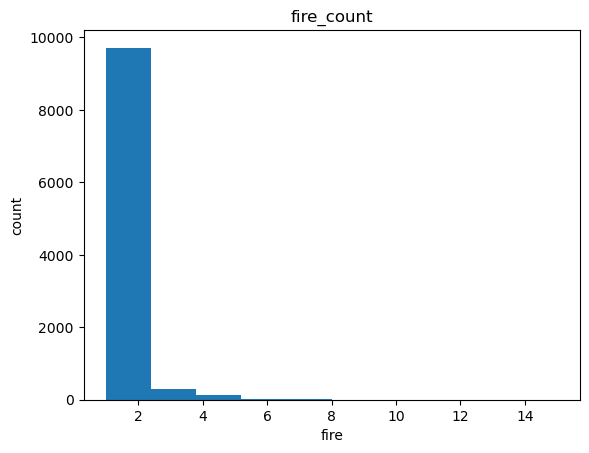

In [419]:
#화재 발생 건수 / 총 행의 수  --> 화재는 실제 발생 데이터가 매우 작은 것을 확인할 수 있다.
print('화재발생건수',code[(code.fire_count > 0)].fire_count.count())
print('화재 발생 안한 수',code.shape[0] - code[(code.fire_count > 0)].fire_count.count())

#응급발생건수 / 총 행수
print('응급발생건수',code[(code.emg_count > 0)].emg_count.count())
print('응급발생안한 수',code.shape[0] - code[(code.emg_count > 0)].emg_count.count() )

#화재 발생 건수 분포 --> 대부분 1,2건에 대부분 몰려있다. 정확하지 않지만 y/n의 이진 분류로 계산하는 것이 좋을 듯하다
print('\n',code['fire_count'].value_counts())
plt.hist(code['fire_count'])
plt.xlabel('fire')
plt.ylabel('count')
plt.title('fire_count')
plt.show()

## 1.화재 발생 예측 모델

In [420]:
code

,code,total_pop,avg_age,pop_dens,eld_dep_ratio,total_house,ho_ar_001,ho_ar_002,ho_ar_003,ho_ar_004,ho_ar_005,ho_ar_006,ho_ar_007,ho_ar_008,ho_ar_009,ho_ar_999,1970s,1980s,1990s,2000-2004,2005-2009,2010-2014,2015-2020,no_yr_data,ho_gb_001,ho_gb_002,ho_gb_003,ho_gb_004,ho_gb_005,ho_gb_006,ho_gb_999,total_corp,cp_bnu_001,cp_bnu_002,cp_bnu_003,cp_bnu_004,cp_bnu_005,cp_bnu_006,cp_bnu_007,cp_bnu_008,cp_bnu_009,cp_bnu_010,cp_bnu_011,cp_bnu_012,cp_bnu_013,cp_bnu_014,cp_bnu_015,cp_bnu_016,cp_bnu_017,cp_bnu_018,cp_bnu_019,cp_bnu_999,cp_bem_001,cp_bem_002,cp_bem_003,cp_bem_004,cp_bem_005,cp_bem_006,cp_bem_007,cp_bem_008,cp_bem_009,cp_bem_010,cp_bem_011,cp_bem_012,cp_bem_013,cp_bem_014,cp_bem_015,cp_bem_016,cp_bem_017,cp_bem_018,cp_bem_019,cp_bem_999,do_index,si_index,dong_index,si_name,dong_name,year,season,city0,year0,avg_temp(℃)0,avg_high_temp(℃)0,avg_low_temp(℃)0,avg_hum(%rh)0,rain(mm)0,avg_wind(m/s)0,max_wind(m/s)0,month0,avg_temp(℃)1,avg_high_temp(℃)1,avg_low_temp(℃)1,avg_hum(%rh)1,rain(mm)1,avg_wind(m/s)1,max_wind(m/s)1,month1,avg_temp(℃)2,avg_high_temp(℃)2,avg_low_temp(℃)2,avg_hum(%rh)2,rain(mm)2,avg_wind(m/s)2,max_wind(m/s)2,month2,qu_se,fire_count,prprty_dmge_sum,fire_dsp_reqre_avg_time,emg_count,emg_dsp_reqre_avg_time
0,35011600010001,597,42.8,10347.1,143.0,169,0.0,0.0,5.0,51.0,36.0,25.0,33.0,12.0,0.0,0.0,95.0,27.0,15.0,5.0,0.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,10.0,306.67
1,35011600010002,884,42.9,3981.5,211.8,230,0.0,7.0,19.0,66.0,37.0,29.0,44.0,18.0,9.0,0.0,116.0,26.0,17.0,0.0,9.0,0.0,0.0,0.0,0.0,229.0,0.0,0.0,0.0,0.0,0.0,90,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,78.0,0.0,0.0,0.0,0.0,21.0,15.0,0.0,5.0,7.0,24.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,1.0,1.0,22591.0,206.0,7.0,380.00
2,35011600010003,889,28.6,6742.7,276.5,82,0.0,0.0,8.0,26.0,6.0,11.0,8.0,13.0,9.0,0.0,42.0,0.0,0.0,15.0,23.0,0.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,0.0,31,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,0.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,114.0,9.0,0.0,13.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,2.0,450.00
3,35011600020001,556,43.6,721.5,132.1,174,0.0,6.0,32.0,82.0,22.0,11.0,12.0,8.0,0.0,0.0,26.0,32.0,81.0,5.0,0.0,0.0,0.0,0.0,0.0,101.0,70.0,0.0,0.0,0.0,0.0,51,0.0,0.0,9.0,0.0,0.0,6.0,17.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,47.0,52.0,7.0,17.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,5.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,4.0,450.00
4,35011600020002,550,45.7,136.9,208.8,217,0.0,6.0,85.0,46.0,39.0,15.0,14.0,5.0,7.0,0.0,39.0,30.0,96.0,10.0,0.0,0.0,0.0,0.0,0.0,119.0,70.0,27.0,0.0,0.0,0.0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,17.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,9.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### 불필요한 항 제거하고 화재발생건수를 이진분류위한 y/n로 준비

In [421]:
fire = code.copy()

#기본적으로 제외해야할 것
fire.drop(['ho_ar_999','no_yr_data','ho_gb_999','cp_bnu_999','cp_bem_999','do_index','si_name','dong_name',
          'city0','year0','month0','month1','month2','qu_se'],axis=1,inplace=True)

#화재 발생 건수만 남기기
fire.drop(['prprty_dmge_sum','fire_dsp_reqre_avg_time','emg_count','emg_dsp_reqre_avg_time'],axis =1,inplace=True)

#화재 건수를 yn로 변경하기
fire.loc[fire['fire_count'] >= 1,'fire_count'] = 'Y' 
fire['fire_count'].fillna('N',inplace=True) 

cols = fire.select_dtypes('object').columns

print(cols)

main_ = fire.copy()

for i in cols:
    main_[i] = pd.Categorical(main_[i]).codes
    main_[i] = main_[i].astype('int')


fire = main_.copy()
fire

Index(['fire_count'], dtype='object')


,code,total_pop,avg_age,pop_dens,eld_dep_ratio,total_house,ho_ar_001,ho_ar_002,ho_ar_003,ho_ar_004,ho_ar_005,ho_ar_006,ho_ar_007,ho_ar_008,ho_ar_009,1970s,1980s,1990s,2000-2004,2005-2009,2010-2014,2015-2020,ho_gb_001,ho_gb_002,ho_gb_003,ho_gb_004,ho_gb_005,ho_gb_006,total_corp,cp_bnu_001,cp_bnu_002,cp_bnu_003,cp_bnu_004,cp_bnu_005,cp_bnu_006,cp_bnu_007,cp_bnu_008,cp_bnu_009,cp_bnu_010,cp_bnu_011,cp_bnu_012,cp_bnu_013,cp_bnu_014,cp_bnu_015,cp_bnu_016,cp_bnu_017,cp_bnu_018,cp_bnu_019,cp_bem_001,cp_bem_002,cp_bem_003,cp_bem_004,cp_bem_005,cp_bem_006,cp_bem_007,cp_bem_008,cp_bem_009,cp_bem_010,cp_bem_011,cp_bem_012,cp_bem_013,cp_bem_014,cp_bem_015,cp_bem_016,cp_bem_017,cp_bem_018,cp_bem_019,si_index,dong_index,year,season,avg_temp(℃)0,avg_high_temp(℃)0,avg_low_temp(℃)0,avg_hum(%rh)0,rain(mm)0,avg_wind(m/s)0,max_wind(m/s)0,avg_temp(℃)1,avg_high_temp(℃)1,avg_low_temp(℃)1,avg_hum(%rh)1,rain(mm)1,avg_wind(m/s)1,max_wind(m/s)1,avg_temp(℃)2,avg_high_temp(℃)2,avg_low_temp(℃)2,avg_hum(%rh)2,rain(mm)2,avg_wind(m/s)2,max_wind(m/s)2,fire_count
0,35011600010001,597,42.8,10347.1,143.0,169,0.0,0.0,5.0,51.0,36.0,25.0,33.0,12.0,0.0,95.0,27.0,15.0,5.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,11,600,11,1,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,0
1,35011600010002,884,42.9,3981.5,211.8,230,0.0,7.0,19.0,66.0,37.0,29.0,44.0,18.0,9.0,116.0,26.0,17.0,0.0,9.0,0.0,0.0,0.0,229.0,0.0,0.0,0.0,0.0,90,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,78.0,0.0,0.0,0.0,0.0,21.0,15.0,0.0,5.0,7.0,24.0,11,600,11,1,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,1
2,35011600010003,889,28.6,6742.7,276.5,82,0.0,0.0,8.0,26.0,6.0,11.0,8.0,13.0,9.0,42.0,0.0,0.0,15.0,23.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,31,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,0.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,114.0,9.0,0.0,13.0,11,600,11,1,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,0
3,35011600020001,556,43.6,721.5,132.1,174,0.0,6.0,32.0,82.0,22.0,11.0,12.0,8.0,0.0,26.0,32.0,81.0,5.0,0.0,0.0,0.0,0.0,101.0,70.0,0.0,0.0,0.0,51,0.0,0.0,9.0,0.0,0.0,6.0,17.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,47.0,52.0,7.0,17.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,5.0,11,600,11,1,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,0
4,35011600020002,550,45.7,136.9,208.8,217,0.0,6.0,85.0,46.0,39.0,15.0,14.0,5.0,7.0,39.0,30.0,96.0,10.0,0.0,0.0,0.0,0.0,119.0,70.0,27.0,0.0,0.0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,7.0,17.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,9.0,11,600,11,1,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147635,35580420010191,36,59.6,19.0,0.0,10,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,580,420,20,4,21.0,25.8,12.8,84,224.3,1.5,9.3,14.5,20.5,4.1,73,6.8,1.2,5.4,9.4,14.6,-0.5,75,49.4,1.3,7.8,0
147636,35580420010205,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### 11~19년도 : 학습데이터 , 20년도 : 테스트(평가)데이터

In [422]:
import xgboost as xgb
from xgboost import plot_importance

#기존에 연도별로 데이터가 주어졌을 때 데이터 셋 만드는 함수

train = fire[fire.year != 20]
test = fire[fire.year == 20]

fire_train_data = train.drop(columns=['fire_count'],axis=1)
fire_train_labels = train['fire_count']

fire_test_data = test.drop(columns=['fire_count'],axis=1)
fire_test_labels = test['fire_count']


fire_dtrain = xgb.DMatrix(fire_train_data,label= fire_train_labels)
fire_dtest = xgb.DMatrix(fire_test_data,fire_test_labels)

### 연도별로 나누지 않고 랜덤하게 나누어 학습 데이터, 테스트 데이터 구성

In [31]:
#이건 랜덤하게 데이터셋을 구성할 때 사용

from sklearn.model_selection import train_test_split

data = fire.drop('fire_count',axis=1)
labels = fire['fire_count']

# 데이터를 랜덤하게 일정 비율로 나누기
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)



### 모델 학습

In [423]:
import xgboost as xgb
from xgboost import plot_importance

#불균형 해결 위한 가중치
class_weights = 13.5 #음성 수 / 양성 수

fire_dtrain = xgb.DMatrix(fire_train_data,label= fire_train_labels)
fire_dtest = xgb.DMatrix(fire_test_data,fire_test_labels)

param = { 'max_depth':10,
         'eta':0.01,
         'subsample' : 0.5,
         'colsample_bytree':0.5,
         'objective': 'binary:logistic',
         "scale_pos_weight": class_weights,
         'eval_metric':'error'}

num_round=1000

wlist = [(fire_dtrain,'train'),(fire_dtest,'eval')]

fire_model = xgb.train(params=param,dtrain=fire_dtrain,num_boost_round=num_round,evals=wlist)




[0]	train-error:0.28748	eval-error:0.31976
[1]	train-error:0.25066	eval-error:0.28488
[2]	train-error:0.23853	eval-error:0.27892
[3]	train-error:0.24024	eval-error:0.27344
[4]	train-error:0.23837	eval-error:0.27106
[5]	train-error:0.23730	eval-error:0.26368
[6]	train-error:0.23521	eval-error:0.26219
[7]	train-error:0.23363	eval-error:0.26057
[8]	train-error:0.23393	eval-error:0.25941
[9]	train-error:0.23469	eval-error:0.26097
[10]	train-error:0.23379	eval-error:0.26307
[11]	train-error:0.23448	eval-error:0.26185
[12]	train-error:0.23519	eval-error:0.26355
[13]	train-error:0.23420	eval-error:0.25935
[14]	train-error:0.23271	eval-error:0.26097
[15]	train-error:0.23150	eval-error:0.26002
[16]	train-error:0.23164	eval-error:0.25860
[17]	train-error:0.23115	eval-error:0.25677
[18]	train-error:0.22987	eval-error:0.25576
[19]	train-error:0.23001	eval-error:0.25549
[20]	train-error:0.23057	eval-error:0.25772
[21]	train-error:0.23158	eval-error:0.25935
[22]	train-error:0.23131	eval-error:0.2596

### 화재 발생 예측에 대해서 데이터의 불균형이 너무 커서 그런지 예측의 정확도가 매우 떨어지는 경향을 볼 수 있다.

[0.22684239 0.48818615 0.26147574 ... 0.00086412 0.00086412 0.00086412]
best_f1 :  0.3317676143386898 최적 임계값 :  0.47000000000000003
오차행렬:
 [[11390  2136]
 [  567   671]]

정확도: 0.8169
정밀도: 0.2390
재현율: 0.5420
F1: 0.3318
AUC: 0.1680


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

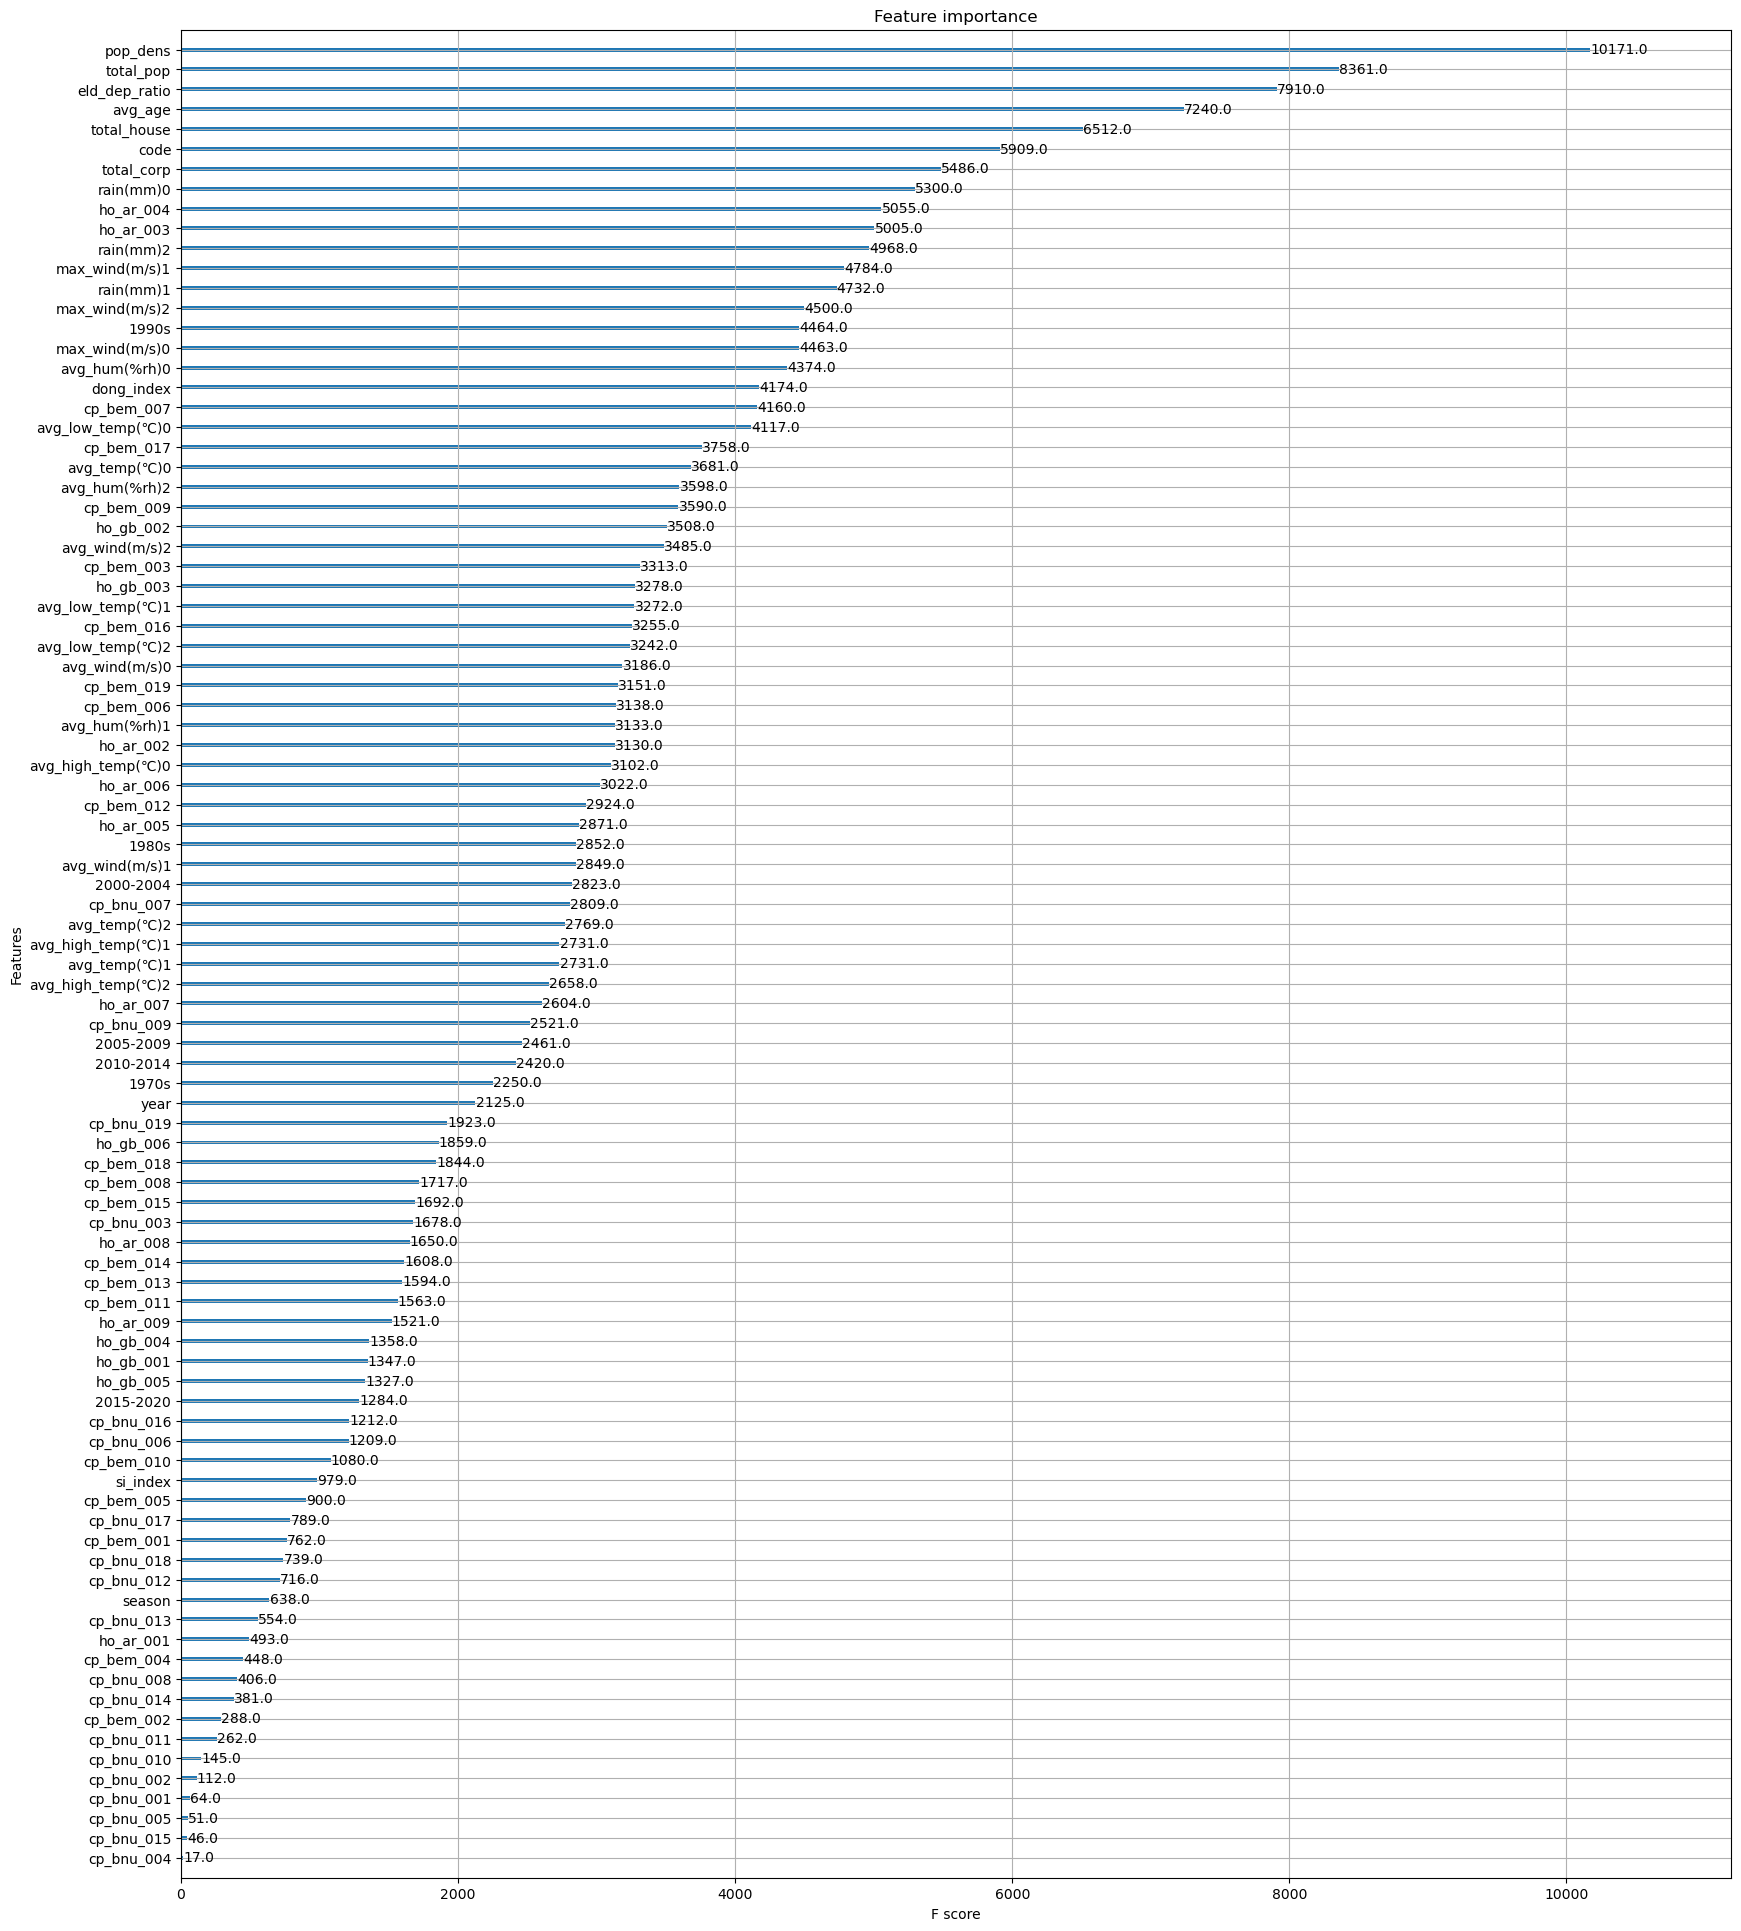

In [426]:
fire_pred = fire_model.predict(fire_dtest)
print(fire_pred)

best_i = 0
best_f1 = 0

for val in np.arange(0,1,0.01):
    preds = [ 1 if x > val else 0 for x in fire_pred]
    f1 = f1_score(fire_test_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_i = val

print('best_f1 : ',best_f1,'최적 임계값 : ',best_i)

preds = [ 1 if x > best_i else 0 for x in fire_pred]
get_clf_eval(fire_test_labels, preds)
fig,ax = plt.subplots(figsize=(20,24))
plot_importance(fire_model,ax=ax)

### 모델 저장하기

In [427]:
fire_model.save_model('xgb_fire.bin')

# 2.화재발생피해와 변수간의 관계 분석


In [428]:
#화재 발생 횟수만 남기도 드롭 시킨 후 yn로 변환하기

fire_damage = code.copy()

#기본적으로 제외해야할 것
fire_damage.drop(['ho_ar_999','no_yr_data','ho_gb_999','cp_bnu_999','cp_bem_999','do_index','si_name','dong_name',
          'city0','year0','month0','month1','month2','qu_se','code'],axis=1,inplace=True)

#화재 발생 피해만 남기기
fire_damage.drop(['fire_count','fire_dsp_reqre_avg_time','emg_count','emg_dsp_reqre_avg_time'],axis =1,inplace=True)

fire_damage['prprty_dmge_sum'].fillna(0,inplace=True) 

cols = fire_damage.select_dtypes('object').columns

print(cols)

main_ = fire_damage.copy()

for i in cols:
    main_[i] = pd.Categorical(main_[i]).codes
    main_[i] = main_[i].astype('int')


fire_damage = main_.copy()
fire_damage = fire_damage[fire_damage['prprty_dmge_sum'] != 0]
fire_damage

Index([], dtype='object')


,total_pop,avg_age,pop_dens,eld_dep_ratio,total_house,ho_ar_001,ho_ar_002,ho_ar_003,ho_ar_004,ho_ar_005,ho_ar_006,ho_ar_007,ho_ar_008,ho_ar_009,1970s,1980s,1990s,2000-2004,2005-2009,2010-2014,2015-2020,ho_gb_001,ho_gb_002,ho_gb_003,ho_gb_004,ho_gb_005,ho_gb_006,total_corp,cp_bnu_001,cp_bnu_002,cp_bnu_003,cp_bnu_004,cp_bnu_005,cp_bnu_006,cp_bnu_007,cp_bnu_008,cp_bnu_009,cp_bnu_010,cp_bnu_011,cp_bnu_012,cp_bnu_013,cp_bnu_014,cp_bnu_015,cp_bnu_016,cp_bnu_017,cp_bnu_018,cp_bnu_019,cp_bem_001,cp_bem_002,cp_bem_003,cp_bem_004,cp_bem_005,cp_bem_006,cp_bem_007,cp_bem_008,cp_bem_009,cp_bem_010,cp_bem_011,cp_bem_012,cp_bem_013,cp_bem_014,cp_bem_015,cp_bem_016,cp_bem_017,cp_bem_018,cp_bem_019,si_index,dong_index,year,season,avg_temp(℃)0,avg_high_temp(℃)0,avg_low_temp(℃)0,avg_hum(%rh)0,rain(mm)0,avg_wind(m/s)0,max_wind(m/s)0,avg_temp(℃)1,avg_high_temp(℃)1,avg_low_temp(℃)1,avg_hum(%rh)1,rain(mm)1,avg_wind(m/s)1,max_wind(m/s)1,avg_temp(℃)2,avg_high_temp(℃)2,avg_low_temp(℃)2,avg_hum(%rh)2,rain(mm)2,avg_wind(m/s)2,max_wind(m/s)2,prprty_dmge_sum
1,884,42.9,3981.5,211.8,230,0.0,7.0,19.0,66.0,37.0,29.0,44.0,18.0,9.0,116.0,26.0,17.0,0.0,9.0,0.0,0.0,0.0,229.0,0.0,0.0,0.0,0.0,90,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,78.0,0.0,0.0,0.0,0.0,21.0,15.0,0.0,5.0,7.0,24.0,11,600,11,1,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,22591.0
15,643,42.6,545.8,162.9,214,0.0,13.0,17.0,35.0,115.0,15.0,11.0,0.0,0.0,43.0,23.0,16.0,11.0,0.0,0.0,0.0,0.0,107.0,97.0,9.0,0.0,0.0,46,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,30.0,0.0,0.0,0.0,19.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,16.0,11,610,11,1,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,4990.0
37,229,58.1,1662.7,972.7,27,0.0,0.0,0.0,5.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,8.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,9.0,6.0,269,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,159.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,11.0,13.0,20.0,0.0,0.0,0.0,0.0,0.0,5.0,140.0,0.0,577.0,20.0,46.0,0.0,28.0,0.0,41.0,12.0,158.0,21.0,83.0,11,620,11,1,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,2268.0
79,237,35.6,1584.8,61.5,32,0.0,0.0,0.0,0.0,0.0,5.0,5.0,6.0,10.0,0.0,0.0,15.0,23.0,25.0,0.0,0.0,0.0,24.0,0.0,0.0,8.0,0.0,178,0.0,0.0,0.0,0.0,0.0,14.0,48.0,0.0,28.0,0.0,0.0,6.0,6.0,0.0,0.0,23.0,14.0,9.0,18.0,0.0,0.0,6.0,0.0,0.0,126.0,258.0,12.0,99.0,97.0,20.0,11.0,69.0,47.0,0.0,76.0,164.0,19.0,82.0,11,630,11,1,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,1481.0
82,466,32.1,5846.7,13.2,55,0.0,0.0,0.0,5.0,0.0,12.0,15.0,0.0,17.0,0.0,0.0,9.0,50.0,12.0,0.0,0.0,5.0,34.0,0.0,0.0,16.0,0.0,229,0.0,0.0,6.0,0.0,0.0,26.0,51.0,0.0,57.0,0.0,0.0,7.0,15.0,0.0,0.0,16.0,0.0,15.0,25.0,0.0,0.0,19.0,0.0,7.0,525.0,171.0,0.0,211.0,17.0,22.0,16.0,48.0,21.0,0.0,69.0,9.0,26.0,60.0,11,630,11,1,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,313.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147616,504,48.9,157.9,327.3,192,0.0,27.0,59.0,54.0,40.0,5.0,0.0,0.0,0.0,103.0,23.0,35.0,12.0,8.0,0.0,0.0,0.0,191.0,0.0,0.0,0.0,11.0,81,0.0,0.0,5.0,29.0,0.0,5.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,20.0,0.0,11.0,29.0,0.0,21.0,25.0,0.0,8.0,0.0,5.0,0.0,0.0,0.0,65.0,58.0,69.0,0.0,6.0,580,380,20,4,21.0,25.8,12.8,84,224.3,1.5,9.3,14.5,20.5,4.1,73,6.8,1.2,5.4,9.4,14.6,-0.5,75,49.4,1.3,7.8,3593.0
147621,444,60.9,100.1,1958.3,212,0.0,19.0,43.0,66.0,65.0,9.0,6.0,0.0,0.0,94.0,12.0,49.0,16.0,11.0,5.0,6.0,0.0,210.0,0.0,0.0,0.0,8.0,51,0.0,0.0,7.0,6.0,0.0,0.0,17.0,0.

### 화재발생 피해와 변수들의 상관관계

In [429]:
# 상관계수 계산
correlation_matrix = fire_damage.corr()

# 특정 열과의 상관계수 선택
correlations_with_target = correlation_matrix['prprty_dmge_sum'].abs().sort_values(ascending=False)

corr_ = correlations_with_target
corr_ = corr_.reset_index()
corr_


,index,prprty_dmge_sum
0,prprty_dmge_sum,1.000000
1,cp_bnu_003,0.095906
2,total_corp,0.068502
3,ho_gb_006,0.065180
4,cp_bem_004,0.061050
...,...,...
87,cp_bem_018,0.002158
88,cp_bnu_019,0.001946
89,avg_wind(m/s)0,0.000755
90,2005-2009,0.000679


# 3. 화재,응급 평균 도착시간 특징 확인

### 화재 도착시간 분포

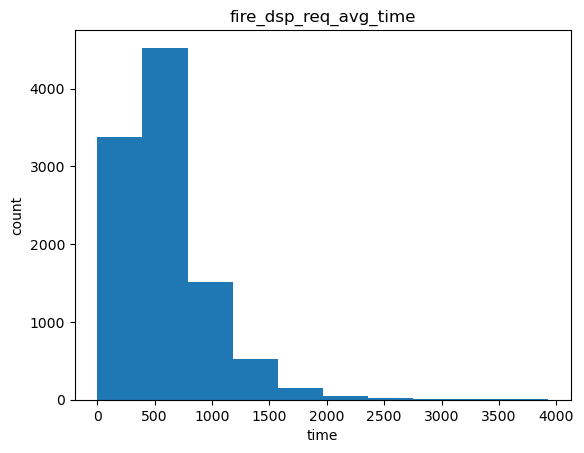

In [431]:
plt.hist(code['fire_dsp_reqre_avg_time'])
plt.xlabel('time')
plt.ylabel('count')
plt.title('fire_dsp_req_avg_time')
plt.show()

### 응급 도착시간 분포

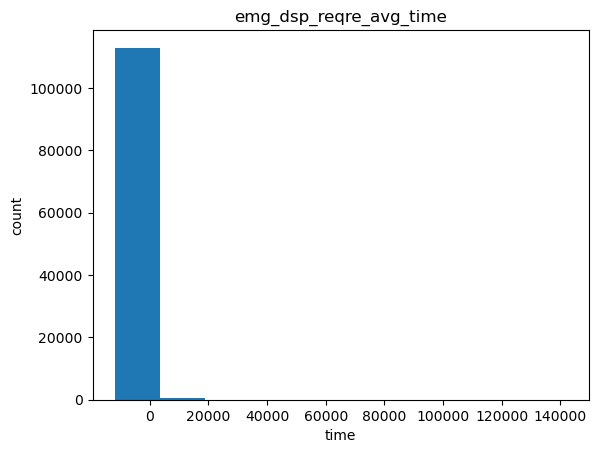

[-11842.5 -11540.  -10800.  ... 141900.  141960.       nan]


In [432]:
plt.hist(code['emg_dsp_reqre_avg_time'])
plt.xlabel('time')
plt.ylabel('count')
plt.title('emg_dsp_reqre_avg_time')
plt.show()

print(np.sort(code['emg_dsp_reqre_avg_time'].unique()))

### 골든시간에 따른 화재 사건 분석

In [433]:
#화재 사건 도착에 대한 분석 --> 대부분 도착시간이 5분 이상 걸리는 것을 확인할 수 있다.

under = code[code['fire_dsp_reqre_avg_time'] <= 300]
upper = code[code['fire_dsp_reqre_avg_time'] > 300]

# print(under['fire_dsp_reqre_avg_time'].value_counts())
# print(upper['fire_dsp_reqre_avg_time'].value_counts())
print('화재 골든타임 내 도착 건수 : ',under['fire_dsp_reqre_avg_time'].count())
print('화재 골든타임 지난 도착 건수 : ',upper['fire_dsp_reqre_avg_time'].count())
print('총 화재 건수 : ',code['fire_dsp_reqre_avg_time'].count())

화재 골든타임 내 도착 건수 :  1737
화재 골든타임 지난 도착 건수 :  8455
총 화재 건수 :  10192


### 골든시간에 따른 응급사건 분석

In [434]:
#응급사건 도착 시간 분석 --> 대부분 5분 내로 도착하지 못함

under = code[code['emg_dsp_reqre_avg_time'] <= 300]
upper = code[code['emg_dsp_reqre_avg_time'] > 300]

# print(under['emg_dsp_reqre_avg_time'].value_counts())
# print(upper['emg_dsp_reqre_avg_time'].value_counts())
print('골든시간 내 응급사건 수 : ',under['emg_dsp_reqre_avg_time'].count())
print('골든시간 지난 응급사건 수',upper['emg_dsp_reqre_avg_time'].count())
print('총 응금사건 수',code['emg_dsp_reqre_avg_time'].count())


골든시간 내 응급사건 수 :  20372
골든시간 지난 응급사건 수 93169
총 응금사건 수 113541


# 4. 연간 데이터 기반 화재 발생 예측

In [448]:
#각 연도별 집계구 데이터 불러오기

code_11 = pd.read_csv('./code_data/ycode_2011.csv',encoding='EUC-KR')
code_12 = pd.read_csv('./code_data/ycode_2012.csv',encoding='EUC-KR')
code_13 = pd.read_csv('./code_data/ycode_2013.csv',encoding='EUC-KR')
code_14 = pd.read_csv('./code_data/ycode_2014.csv',encoding='EUC-KR')
code_15 = pd.read_csv('./code_data/ycode_2015.csv',encoding='EUC-KR')
code_16 = pd.read_csv('./code_data/ycode_2016.csv',encoding='EUC-KR')
code_17 = pd.read_csv('./code_data/ycode_2017.csv',encoding='EUC-KR')
code_18 = pd.read_csv('./code_data/ycode_2018.csv',encoding='EUC-KR')
code_19 = pd.read_csv('./code_data/ycode_2019.csv',encoding='EUC-KR')
code_20 = pd.read_csv('./code_data/ycode_2020.csv',encoding='EUC-KR')

code_list = [code_11,code_12,code_13,code_14,code_15,code_16,code_17,code_18,code_19,code_20]

for i in range(0,10):
    code_list[i]['year'] = i+11

code_year = pd.concat(code_list,axis=0)
code_year = code_year.reset_index()
code_year = code_year.drop(['index'],axis=1)
code_year = code_year.iloc[:,1:]
code_year = code_year.rename({'Unnamed: 0' : 'code'},axis=1)
code_year

,code,total_pop,avg_age,pop_dens,eld_dep_ratio,total_house,ho_ar_001,ho_ar_002,ho_ar_003,ho_ar_004,ho_ar_005,ho_ar_006,ho_ar_007,ho_ar_008,ho_ar_009,ho_ar_999,1970s,1980s,1990s,2000-2004,2005-2009,2010-2014,2015-2020,no_yr_data,ho_gb_001,ho_gb_002,ho_gb_003,ho_gb_004,ho_gb_005,ho_gb_006,ho_gb_999,total_corp,cp_bnu_001,cp_bnu_002,cp_bnu_003,cp_bnu_004,cp_bnu_005,cp_bnu_006,cp_bnu_007,cp_bnu_008,cp_bnu_009,cp_bnu_010,cp_bnu_011,cp_bnu_012,cp_bnu_013,cp_bnu_014,cp_bnu_015,cp_bnu_016,cp_bnu_017,cp_bnu_018,cp_bnu_019,cp_bnu_999,cp_bem_001,cp_bem_002,cp_bem_003,cp_bem_004,cp_bem_005,cp_bem_006,cp_bem_007,cp_bem_008,cp_bem_009,cp_bem_010,cp_bem_011,cp_bem_012,cp_bem_013,cp_bem_014,cp_bem_015,cp_bem_016,cp_bem_017,cp_bem_018,cp_bem_019,cp_bem_999,do_index,si_index,dong_index,fire_count,year
0,35011600010001,597,42.8,10347.1,143.0,169,0.0,0.0,5.0,51.0,36.0,25.0,33.0,12.0,0.0,0.0,95.0,27.0,15.0,5.0,0.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,0.0,35,11,600,NaN,11
1,35011600010002,884,42.9,3981.5,211.8,230,0.0,7.0,19.0,66.0,37.0,29.0,44.0,18.0,9.0,0.0,116.0,26.0,17.0,0.0,9.0,0.0,0.0,0.0,0.0,229.0,0.0,0.0,0.0,0.0,0.0,90,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,78.0,0.0,0.0,0.0,0.0,21.0,15.0,0.0,5.0,7.0,24.0,0.0,35,11,600,1.0,11
2,35011600010003,889,28.6,6742.7,276.5,82,0.0,0.0,8.0,26.0,6.0,11.0,8.0,13.0,9.0,0.0,42.0,0.0,0.0,15.0,23.0,0.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,0.0,31,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,0.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,114.0,9.0,0.0,13.0,0.0,35,11,600,NaN,11
3,35011600020001,556,43.6,721.5,132.1,174,0.0,6.0,32.0,82.0,22.0,11.0,12.0,8.0,0.0,0.0,26.0,32.0,81.0,5.0,0.0,0.0,0.0,0.0,0.0,101.0,70.0,0.0,0.0,0.0,0.0,51,0.0,0.0,9.0,0.0,0.0,6.0,17.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,47.0,52.0,7.0,17.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,5.0,0.0,35,11,600,NaN,11
4,35011600020002,550,45.7,136.9,208.8,217,0.0,6.0,85.0,46.0,39.0,15.0,14.0,5.0,7.0,0.0,39.0,30.0,96.0,10.0,0.0,0.0,0.0,0.0,0.0,119.0,70.0,27.0,0.0,0.0,0.0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,17.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,9.0,0.0,35,11,600,NaN,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36905,35580420010191,36,59.6,19.0,0.0,10,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,580,420,NaN,20
36906,35580420010205,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,35,580,420,NaN,20
36907,35580420010234,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,35,580,420,NaN,20
36908,35580420010255,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### 1년 단위 화재 발생 건수와 분포

화재발생 지역수 :  7827
화재발생 안한 지역수 :  29083

 1.0     4764
2.0     1900
3.0      662
4.0      280
5.0      115
6.0       50
7.0       17
8.0       13
9.0        6
10.0       3
19.0       2
11.0       2
17.0       2
30.0       1
12.0       1
16.0       1
26.0       1
29.0       1
35.0       1
15.0       1
14.0       1
22.0       1
13.0       1
21.0       1
Name: fire_count, dtype: int64


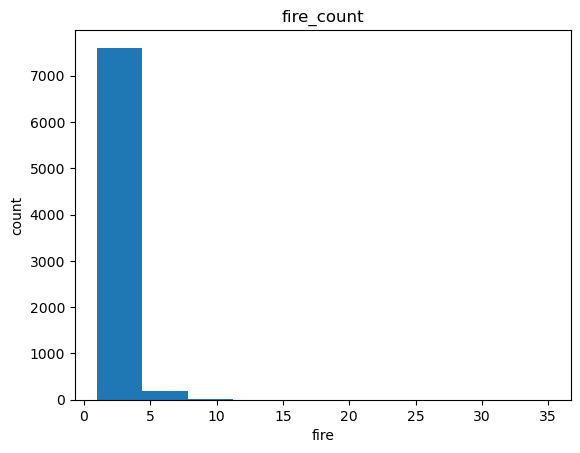

In [449]:
#화재 발생 건수 / 총 행의 수  --> 화재는 실제 발생 데이터가 매우 작은 것을 확인할 수 있다.
print('화재발생 지역수 : ',code_year[(code_year.fire_count > 0)].fire_count.count())
print('화재발생 안한 지역수 : ',code_year.shape[0] - code_year[(code_year.fire_count > 0)].fire_count.count())

#화재 발생 건수 분포 
print('\n',code_year['fire_count'].value_counts())
plt.hist(code_year['fire_count'])
plt.xlabel('fire')
plt.ylabel('count')
plt.title('fire_count')
plt.show()

In [450]:
fire_year = code_year.copy()

#불필요한 항 제거
fire_year.drop(['ho_ar_999','no_yr_data','ho_gb_999','cp_bnu_999','cp_bem_999'],axis=1,inplace=True)

#이진 분류 위한 y/n 처리
fire_year.loc[fire_year['fire_count'] >= 1,'fire_count'] = 'Y' 
fire_year['fire_count'].fillna('N',inplace=True) 

#라벨 인코딩
cols = fire_year.select_dtypes('object').columns

print(cols)

main_ = fire_year.copy()

for i in cols:
    main_[i] = pd.Categorical(main_[i]).codes
    main_[i] = main_[i].astype('int')


fire_year = main_.copy()
fire_year

Index(['fire_count'], dtype='object')


,code,total_pop,avg_age,pop_dens,eld_dep_ratio,total_house,ho_ar_001,ho_ar_002,ho_ar_003,ho_ar_004,ho_ar_005,ho_ar_006,ho_ar_007,ho_ar_008,ho_ar_009,1970s,1980s,1990s,2000-2004,2005-2009,2010-2014,2015-2020,ho_gb_001,ho_gb_002,ho_gb_003,ho_gb_004,ho_gb_005,ho_gb_006,total_corp,cp_bnu_001,cp_bnu_002,cp_bnu_003,cp_bnu_004,cp_bnu_005,cp_bnu_006,cp_bnu_007,cp_bnu_008,cp_bnu_009,cp_bnu_010,cp_bnu_011,cp_bnu_012,cp_bnu_013,cp_bnu_014,cp_bnu_015,cp_bnu_016,cp_bnu_017,cp_bnu_018,cp_bnu_019,cp_bem_001,cp_bem_002,cp_bem_003,cp_bem_004,cp_bem_005,cp_bem_006,cp_bem_007,cp_bem_008,cp_bem_009,cp_bem_010,cp_bem_011,cp_bem_012,cp_bem_013,cp_bem_014,cp_bem_015,cp_bem_016,cp_bem_017,cp_bem_018,cp_bem_019,do_index,si_index,dong_index,fire_count,year
0,35011600010001,597,42.8,10347.1,143.0,169,0.0,0.0,5.0,51.0,36.0,25.0,33.0,12.0,0.0,95.0,27.0,15.0,5.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,35,11,600,0,11
1,35011600010002,884,42.9,3981.5,211.8,230,0.0,7.0,19.0,66.0,37.0,29.0,44.0,18.0,9.0,116.0,26.0,17.0,0.0,9.0,0.0,0.0,0.0,229.0,0.0,0.0,0.0,0.0,90,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,78.0,0.0,0.0,0.0,0.0,21.0,15.0,0.0,5.0,7.0,24.0,35,11,600,1,11
2,35011600010003,889,28.6,6742.7,276.5,82,0.0,0.0,8.0,26.0,6.0,11.0,8.0,13.0,9.0,42.0,0.0,0.0,15.0,23.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,31,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,0.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,114.0,9.0,0.0,13.0,35,11,600,0,11
3,35011600020001,556,43.6,721.5,132.1,174,0.0,6.0,32.0,82.0,22.0,11.0,12.0,8.0,0.0,26.0,32.0,81.0,5.0,0.0,0.0,0.0,0.0,101.0,70.0,0.0,0.0,0.0,51,0.0,0.0,9.0,0.0,0.0,6.0,17.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,47.0,52.0,7.0,17.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,5.0,35,11,600,0,11
4,35011600020002,550,45.7,136.9,208.8,217,0.0,6.0,85.0,46.0,39.0,15.0,14.0,5.0,7.0,39.0,30.0,96.0,10.0,0.0,0.0,0.0,0.0,119.0,70.0,27.0,0.0,0.0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,7.0,17.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,9.0,35,11,600,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36905,35580420010191,36,59.6,19.0,0.0,10,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,580,420,0,20
36906,35580420010205,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,580,420,0,20
36907,35580420010234,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,580,420,0,20
36908,35580420010255,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,580,420,0,20


### 11~19년도 : 학습데이터, 20년도 : 테스트 데이터

In [453]:
import xgboost as xgb
from xgboost import plot_importance

train = fire_year[fire_year.year != 20]
test = fire_year[fire_year.year == 20]

fire_year_train_data = train.drop(columns=['fire_count'],axis=1)
fire_year_train_labels = train['fire_count']

fire_year_test_data = test.drop(columns=['fire_count'],axis=1)
fire_year_test_labels = test['fire_count']

fire_train = xgb.DMatrix(fire_year_train_data,label= fire_year_train_labels)
fire_test = xgb.DMatrix(fire_year_test_data,fire_year_test_labels)

### 모델 학습

In [454]:
class_weights = 4


param = { 'max_depth':6,
         'eta':0.01,
         'subsample' : 0.5,
         'colsample_bytree':0.5,
         'objective': 'binary:logistic',
         "scale_pos_weight": class_weights,
         'eval_metric':'error'}

num_round=3000

wlist = [(fire_train,'train'),(fire_test,'eval')]

fire_year_model = xgb.train(params=param,dtrain=fire_train,num_boost_round=num_round,evals=wlist)

[0]	train-error:0.22906	eval-error:0.24465
[1]	train-error:0.24080	eval-error:0.25549
[2]	train-error:0.24176	eval-error:0.25115
[3]	train-error:0.23845	eval-error:0.24898
[4]	train-error:0.23745	eval-error:0.24898
[5]	train-error:0.23390	eval-error:0.24871
[6]	train-error:0.23375	eval-error:0.24844
[7]	train-error:0.23309	eval-error:0.24817
[8]	train-error:0.23318	eval-error:0.24953
[9]	train-error:0.23357	eval-error:0.25224
[10]	train-error:0.23291	eval-error:0.25251
[11]	train-error:0.23210	eval-error:0.25196
[12]	train-error:0.23339	eval-error:0.25467
[13]	train-error:0.23330	eval-error:0.25386
[14]	train-error:0.23387	eval-error:0.25413
[15]	train-error:0.23360	eval-error:0.25332
[16]	train-error:0.23372	eval-error:0.25359
[17]	train-error:0.23475	eval-error:0.25413
[18]	train-error:0.23502	eval-error:0.25115
[19]	train-error:0.23538	eval-error:0.25142
[20]	train-error:0.23429	eval-error:0.25251
[21]	train-error:0.23342	eval-error:0.25278
[22]	train-error:0.23255	eval-error:0.2533

### 모델 평가

0.6280107047279214 0.54
오차행렬:
 [[2153  610]
 [ 224  704]]

정확도: 0.7740
정밀도: 0.5358
재현율: 0.7586
F1: 0.6280
AUC: 0.4671


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

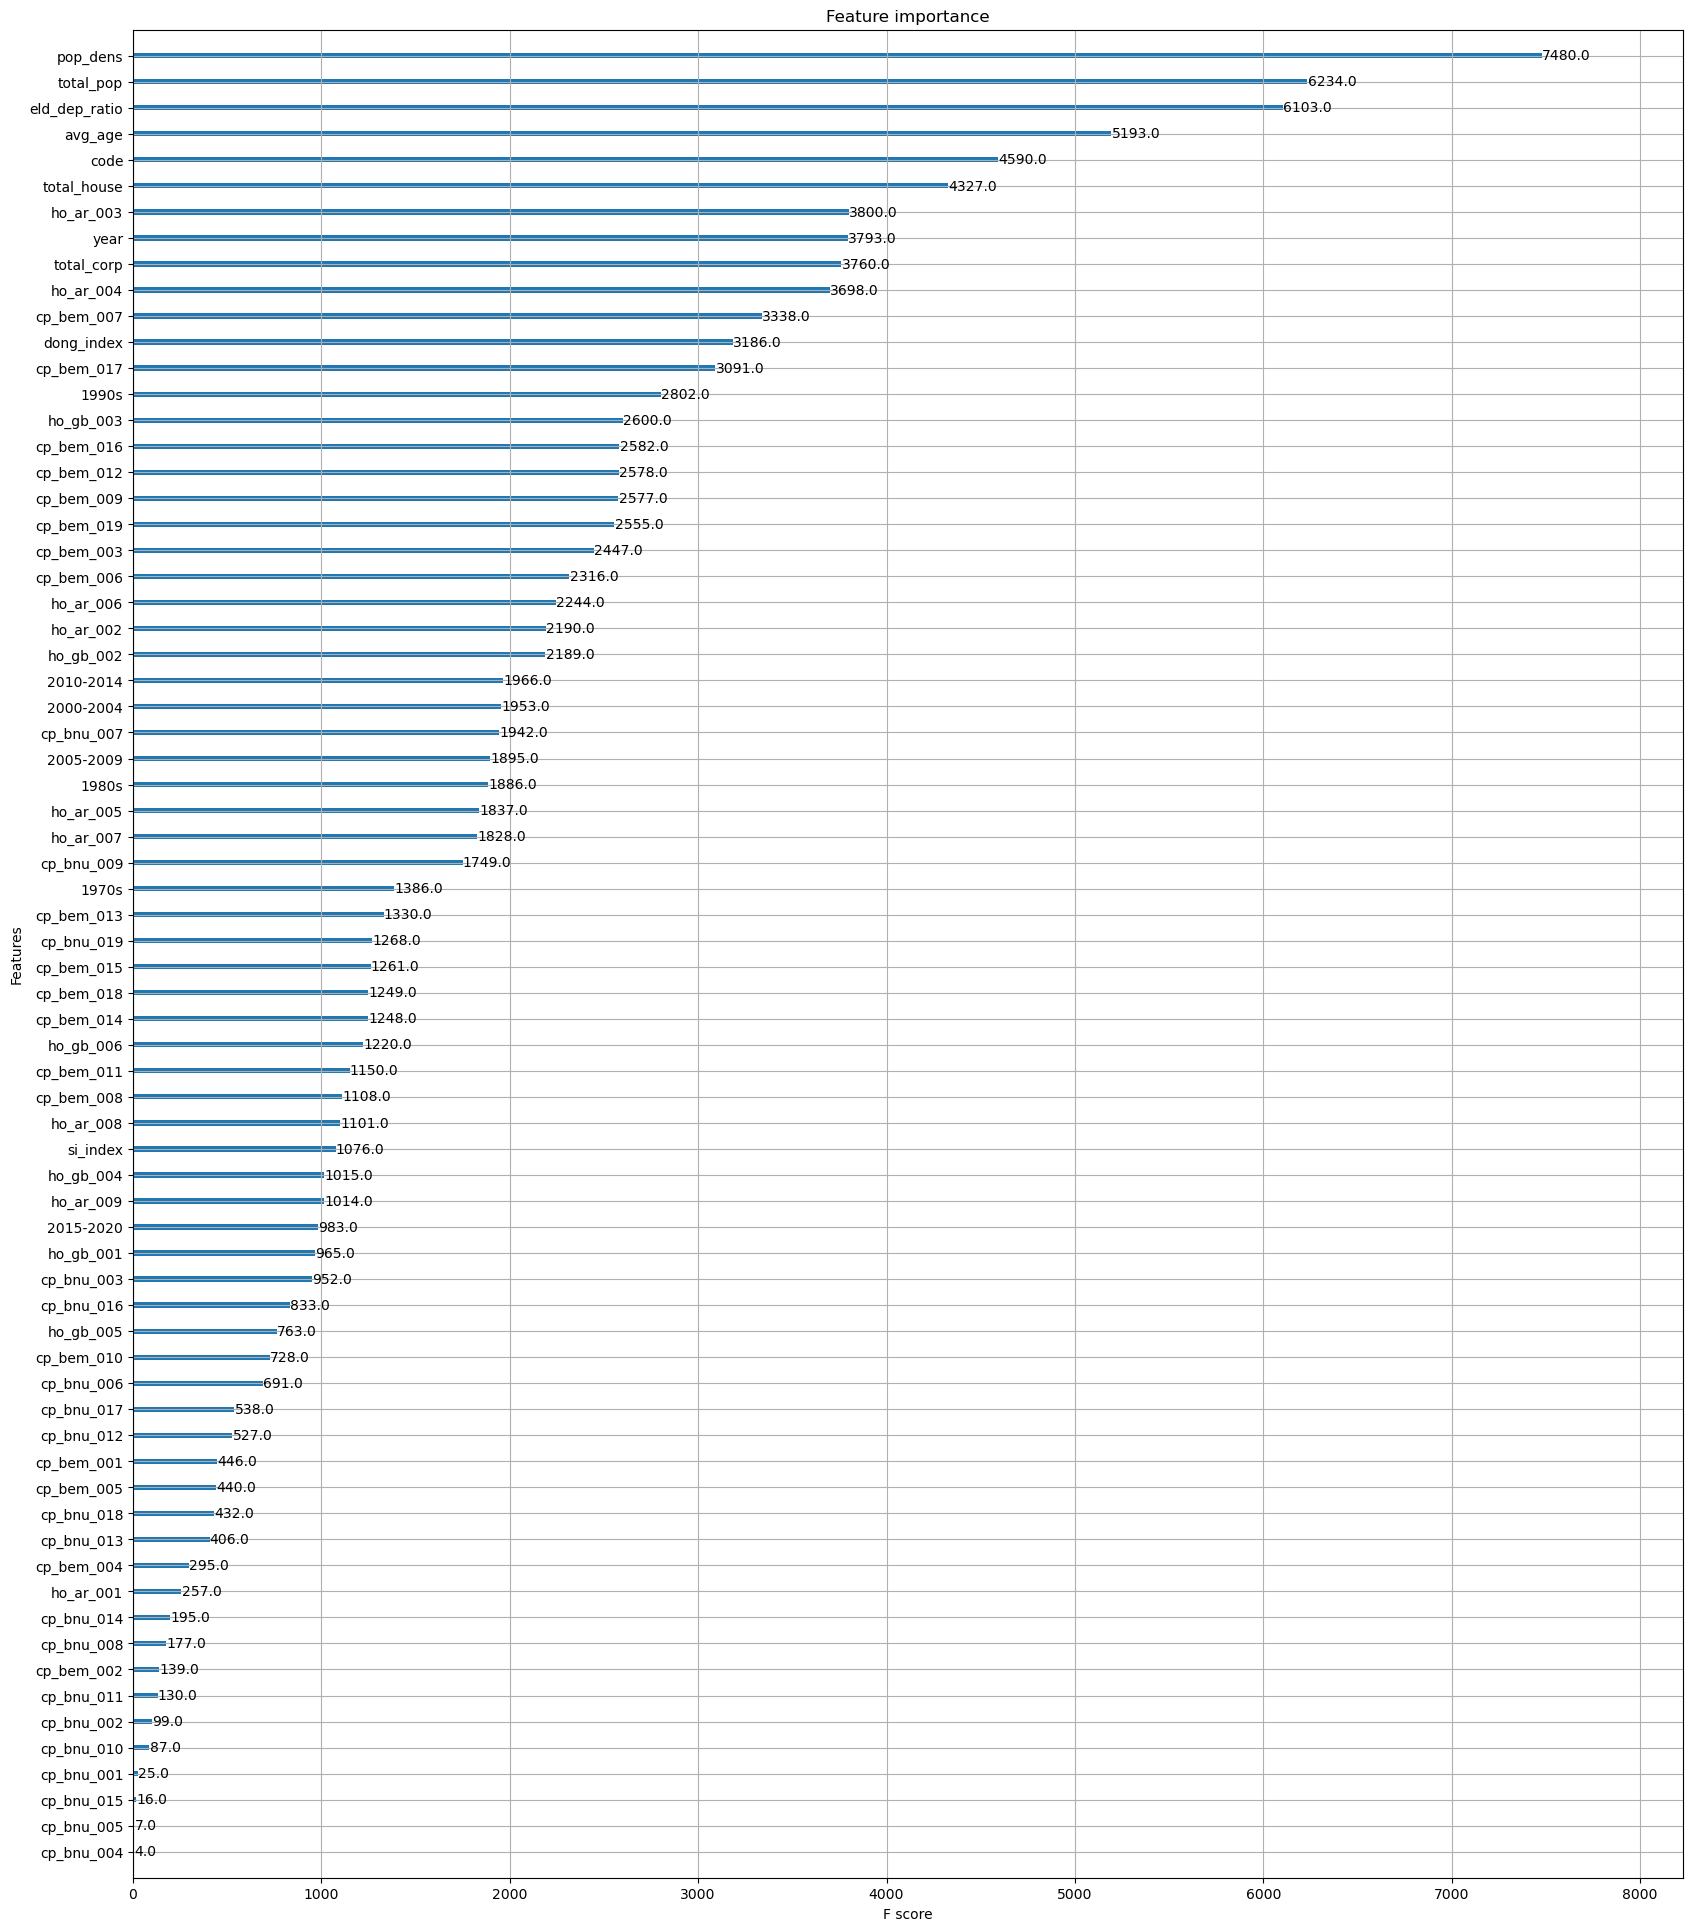

In [455]:
y_pred = fire_year_model.predict(fire_test)

best_i = 0
best_f1 = 0

for val in np.arange(0,1,0.01):
    preds = [ 1 if x > val else 0 for x in y_pred]
    f1 = f1_score(fire_year_test_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_i = val

print(best_f1,best_i)
preds = [ 1 if x > best_i else 0 for x in y_pred]

get_clf_eval(fire_year_test_labels, preds)
fig,ax = plt.subplots(figsize=(20,24))
plot_importance(fire_year_model,ax=ax)

### 모델 저장

In [456]:
fire_year_model.save_model('xgb_fire_year.bin')

### 저장한 모델 불러오기

In [510]:
loaded_model = xgb.Booster()
loaded_model.load_model('xgb_fire_year.bin')

fire_danger = loaded_model.predict(fire_test)
print(fire_danger)

[0.329739   0.534321   0.57746357 ... 0.0051917  0.0051917  0.0051917 ]


### 불러온 모델 평가

In [511]:
best_i = 0
best_f1 = 0

for val in np.arange(0,1,0.01):
    preds = [ 0 if x < val else 1 for x in fire_danger]
    f1 = f1_score(fire_year_test_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_i = val

print(best_f1,best_i)
preds = [ 0 if x < best_i else 1 for x in fire_danger]
get_clf_eval(fire_year_test_labels, preds)


0.6280107047279214 0.54
오차행렬:
 [[2153  610]
 [ 224  704]]

정확도: 0.7740
정밀도: 0.5358
재현율: 0.7586
F1: 0.6280
AUC: 0.4671


0.6280107047279214

## 모델 중 정확도가 제일 좋음

## 연도별로 데이터 셋 하지 않고 랜덤으로 데이터셋 구성해서 학습 후 예측

In [460]:
labels = fire_year['fire_count']
data = fire_year.drop('fire_count',axis=1)

from sklearn.model_selection import train_test_split

# 데이터를 랜덤하게 일정 비율로 나누기
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

fire_rand_train = xgb.DMatrix(train_data,label= train_labels)
fire_rand_test = xgb.DMatrix(test_data,test_labels)

In [464]:
import xgboost as xgb
from xgboost import plot_importance

#ratio = float(np.sum(y == 0)) / np.sum(y == 1)  # 음성 클래스 수 / 양성 클래스 수
class_weights = 4

param = { 'max_depth':6,
         'eta':0.01,
         'subsample' : 0.5,
         'colsample_bytree':0.5,
         'objective': 'binary:logistic',
         "scale_pos_weight": class_weights,
         'eval_metric':'error'}

num_round=3000

wlist = [(fire_rand_train,'train'),(fire_rand_test,'eval')]

fire_year_randmodel = xgb.train(params=param,dtrain=fire_rand_train,num_boost_round=num_round,evals=wlist)

[0]	train-error:0.23720	eval-error:0.24831
[1]	train-error:0.23639	eval-error:0.25115
[2]	train-error:0.23479	eval-error:0.24533
[3]	train-error:0.23425	eval-error:0.24668
[4]	train-error:0.23611	eval-error:0.24885
[5]	train-error:0.23540	eval-error:0.25020
[6]	train-error:0.23479	eval-error:0.25251
[7]	train-error:0.23357	eval-error:0.25237
[8]	train-error:0.23459	eval-error:0.25156
[9]	train-error:0.23469	eval-error:0.25129
[10]	train-error:0.23544	eval-error:0.25305
[11]	train-error:0.23564	eval-error:0.25400
[12]	train-error:0.23598	eval-error:0.25481
[13]	train-error:0.23493	eval-error:0.25345
[14]	train-error:0.23429	eval-error:0.25305
[15]	train-error:0.23388	eval-error:0.25278
[16]	train-error:0.23442	eval-error:0.25278
[17]	train-error:0.23439	eval-error:0.25142
[18]	train-error:0.23439	eval-error:0.25183
[19]	train-error:0.23429	eval-error:0.25291
[20]	train-error:0.23364	eval-error:0.25142
[21]	train-error:0.23256	eval-error:0.24980
[22]	train-error:0.23273	eval-error:0.2493

0.5933819405496354 0.59
오차행렬:
 [[4874  967]
 [ 483 1058]]

정확도: 0.8036
정밀도: 0.5225
재현율: 0.6866
F1: 0.5934
AUC: 0.4241


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

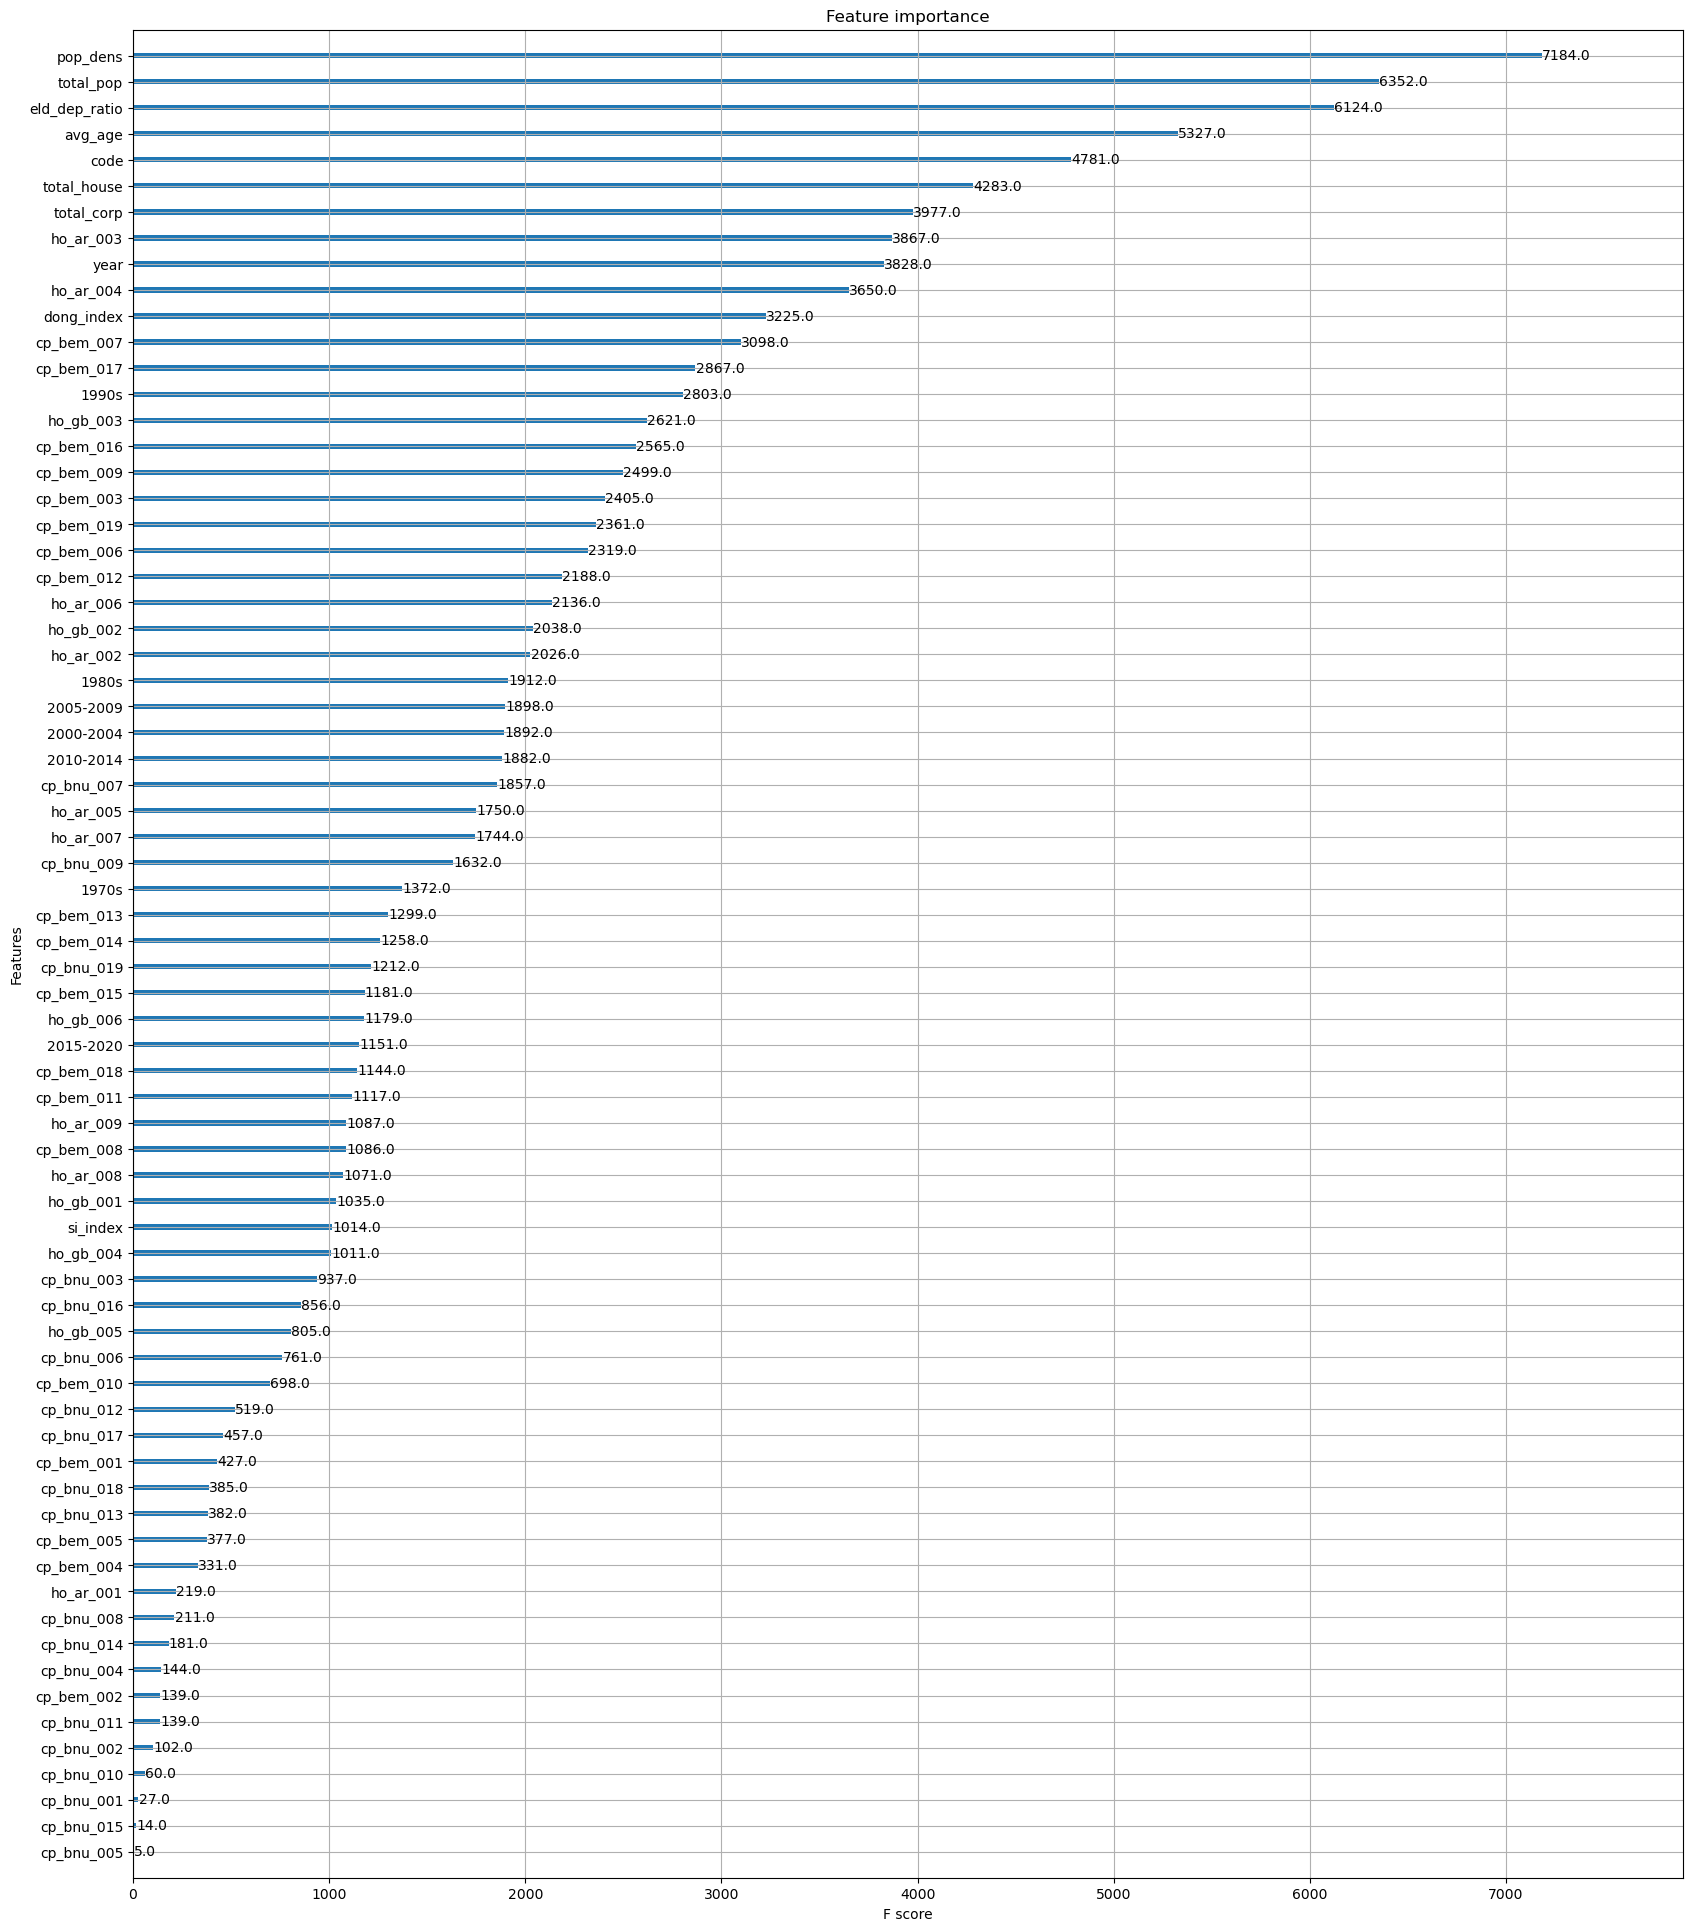

In [465]:
y_pred = fire_year_randmodel.predict(fire_rand_test)

best_i = 0
best_f1 = 0

for val in np.arange(0,1,0.01):
    preds = [ 1 if x > val else 0 for x in y_pred]
    f1 = f1_score(test_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_i = val

print(best_f1,best_i)
preds = [ 1 if x > best_i else 0 for x in y_pred]
get_clf_eval(test_labels, preds)
fig,ax = plt.subplots(figsize=(20,24))
plot_importance(fire_year_randmodel,ax=ax)

### 랜덤으로 학습시킨 모델에 20년도 데이터에 넣기

In [466]:
fire_year_randmodel.save_model('xgb_fire_year_rand.bin')

In [467]:
loaded_model = xgb.Booster()
loaded_model.load_model('xgb_fire_year_rand.bin')

fire_danger_rand = loaded_model.predict(fire_test)

print(fire_danger_rand)

best_i = 0
best_f1 = 0

for val in np.arange(0,1,0.01):
    preds = [ 1 if x > val else 0 for x in fire_danger_rand]
    f1 = f1_score(fire_year_test_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_i = val

print(best_f1,best_i)
preds = [ 1 if x > best_i else 0 for x in fire_danger_rand]
get_clf_eval(fire_year_test_labels, preds)


[0.26821497 0.36688626 0.7476193  ... 0.01377905 0.01377905 0.01377905]
0.7837528604118992 0.74
오차행렬:
 [[2628  135]
 [ 243  685]]

정확도: 0.8976
정밀도: 0.8354
재현율: 0.7381
F1: 0.7838
AUC: 0.6825


0.7837528604118992

# 5. 응급데이터데 예측 모델 생성

In [468]:
#연도별로 전체 합쳐진 code를 사용한다.

code

,code,total_pop,avg_age,pop_dens,eld_dep_ratio,total_house,ho_ar_001,ho_ar_002,ho_ar_003,ho_ar_004,ho_ar_005,ho_ar_006,ho_ar_007,ho_ar_008,ho_ar_009,ho_ar_999,1970s,1980s,1990s,2000-2004,2005-2009,2010-2014,2015-2020,no_yr_data,ho_gb_001,ho_gb_002,ho_gb_003,ho_gb_004,ho_gb_005,ho_gb_006,ho_gb_999,total_corp,cp_bnu_001,cp_bnu_002,cp_bnu_003,cp_bnu_004,cp_bnu_005,cp_bnu_006,cp_bnu_007,cp_bnu_008,cp_bnu_009,cp_bnu_010,cp_bnu_011,cp_bnu_012,cp_bnu_013,cp_bnu_014,cp_bnu_015,cp_bnu_016,cp_bnu_017,cp_bnu_018,cp_bnu_019,cp_bnu_999,cp_bem_001,cp_bem_002,cp_bem_003,cp_bem_004,cp_bem_005,cp_bem_006,cp_bem_007,cp_bem_008,cp_bem_009,cp_bem_010,cp_bem_011,cp_bem_012,cp_bem_013,cp_bem_014,cp_bem_015,cp_bem_016,cp_bem_017,cp_bem_018,cp_bem_019,cp_bem_999,do_index,si_index,dong_index,si_name,dong_name,year,season,city0,year0,avg_temp(℃)0,avg_high_temp(℃)0,avg_low_temp(℃)0,avg_hum(%rh)0,rain(mm)0,avg_wind(m/s)0,max_wind(m/s)0,month0,avg_temp(℃)1,avg_high_temp(℃)1,avg_low_temp(℃)1,avg_hum(%rh)1,rain(mm)1,avg_wind(m/s)1,max_wind(m/s)1,month1,avg_temp(℃)2,avg_high_temp(℃)2,avg_low_temp(℃)2,avg_hum(%rh)2,rain(mm)2,avg_wind(m/s)2,max_wind(m/s)2,month2,qu_se,fire_count,prprty_dmge_sum,fire_dsp_reqre_avg_time,emg_count,emg_dsp_reqre_avg_time
0,35011600010001,597,42.8,10347.1,143.0,169,0.0,0.0,5.0,51.0,36.0,25.0,33.0,12.0,0.0,0.0,95.0,27.0,15.0,5.0,0.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,10.0,306.67
1,35011600010002,884,42.9,3981.5,211.8,230,0.0,7.0,19.0,66.0,37.0,29.0,44.0,18.0,9.0,0.0,116.0,26.0,17.0,0.0,9.0,0.0,0.0,0.0,0.0,229.0,0.0,0.0,0.0,0.0,0.0,90,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,78.0,0.0,0.0,0.0,0.0,21.0,15.0,0.0,5.0,7.0,24.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,1.0,1.0,22591.0,206.0,7.0,380.00
2,35011600010003,889,28.6,6742.7,276.5,82,0.0,0.0,8.0,26.0,6.0,11.0,8.0,13.0,9.0,0.0,42.0,0.0,0.0,15.0,23.0,0.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,0.0,31,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,0.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,114.0,9.0,0.0,13.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,2.0,450.00
3,35011600020001,556,43.6,721.5,132.1,174,0.0,6.0,32.0,82.0,22.0,11.0,12.0,8.0,0.0,0.0,26.0,32.0,81.0,5.0,0.0,0.0,0.0,0.0,0.0,101.0,70.0,0.0,0.0,0.0,0.0,51,0.0,0.0,9.0,0.0,0.0,6.0,17.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,47.0,52.0,7.0,17.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,5.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,4.0,450.00
4,35011600020002,550,45.7,136.9,208.8,217,0.0,6.0,85.0,46.0,39.0,15.0,14.0,5.0,7.0,0.0,39.0,30.0,96.0,10.0,0.0,0.0,0.0,0.0,0.0,119.0,70.0,27.0,0.0,0.0,0.0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,17.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,9.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### qcut을 이용해 3개의 분류로 자르기

In [471]:
emg = code.copy()

emg['emg_count'].fillna(0,inplace=True)
print(emg['emg_count'].value_counts())
labels = ['low','medium','high']
emg['emg_label']= pd.qcut(emg['emg_count'],q=3,labels=labels)

print(emg['emg_label'].value_counts())

emg


0.0      30651
1.0      15793
2.0      12755
3.0      10500
4.0       8810
         ...  
220.0        1
238.0        1
226.0        1
145.0        1
147.0        1
Name: emg_count, Length: 222, dtype: int64
low       59199
high      45042
medium    43399
Name: emg_label, dtype: int64


,code,total_pop,avg_age,pop_dens,eld_dep_ratio,total_house,ho_ar_001,ho_ar_002,ho_ar_003,ho_ar_004,ho_ar_005,ho_ar_006,ho_ar_007,ho_ar_008,ho_ar_009,ho_ar_999,1970s,1980s,1990s,2000-2004,2005-2009,2010-2014,2015-2020,no_yr_data,ho_gb_001,ho_gb_002,ho_gb_003,ho_gb_004,ho_gb_005,ho_gb_006,ho_gb_999,total_corp,cp_bnu_001,cp_bnu_002,cp_bnu_003,cp_bnu_004,cp_bnu_005,cp_bnu_006,cp_bnu_007,cp_bnu_008,cp_bnu_009,cp_bnu_010,cp_bnu_011,cp_bnu_012,cp_bnu_013,cp_bnu_014,cp_bnu_015,cp_bnu_016,cp_bnu_017,cp_bnu_018,cp_bnu_019,cp_bnu_999,cp_bem_001,cp_bem_002,cp_bem_003,cp_bem_004,cp_bem_005,cp_bem_006,cp_bem_007,cp_bem_008,cp_bem_009,cp_bem_010,cp_bem_011,cp_bem_012,cp_bem_013,cp_bem_014,cp_bem_015,cp_bem_016,cp_bem_017,cp_bem_018,cp_bem_019,cp_bem_999,do_index,si_index,dong_index,si_name,dong_name,year,season,city0,year0,avg_temp(℃)0,avg_high_temp(℃)0,avg_low_temp(℃)0,avg_hum(%rh)0,rain(mm)0,avg_wind(m/s)0,max_wind(m/s)0,month0,avg_temp(℃)1,avg_high_temp(℃)1,avg_low_temp(℃)1,avg_hum(%rh)1,rain(mm)1,avg_wind(m/s)1,max_wind(m/s)1,month1,avg_temp(℃)2,avg_high_temp(℃)2,avg_low_temp(℃)2,avg_hum(%rh)2,rain(mm)2,avg_wind(m/s)2,max_wind(m/s)2,month2,qu_se,fire_count,prprty_dmge_sum,fire_dsp_reqre_avg_time,emg_count,emg_dsp_reqre_avg_time,emg_label
0,35011600010001,597,42.8,10347.1,143.0,169,0.0,0.0,5.0,51.0,36.0,25.0,33.0,12.0,0.0,0.0,95.0,27.0,15.0,5.0,0.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,10.0,306.67,high
1,35011600010002,884,42.9,3981.5,211.8,230,0.0,7.0,19.0,66.0,37.0,29.0,44.0,18.0,9.0,0.0,116.0,26.0,17.0,0.0,9.0,0.0,0.0,0.0,0.0,229.0,0.0,0.0,0.0,0.0,0.0,90,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,78.0,0.0,0.0,0.0,0.0,21.0,15.0,0.0,5.0,7.0,24.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,1.0,1.0,22591.0,206.0,7.0,380.00,medium
2,35011600010003,889,28.6,6742.7,276.5,82,0.0,0.0,8.0,26.0,6.0,11.0,8.0,13.0,9.0,0.0,42.0,0.0,0.0,15.0,23.0,0.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,0.0,31,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,0.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,114.0,9.0,0.0,13.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,2.0,450.00,low
3,35011600020001,556,43.6,721.5,132.1,174,0.0,6.0,32.0,82.0,22.0,11.0,12.0,8.0,0.0,0.0,26.0,32.0,81.0,5.0,0.0,0.0,0.0,0.0,0.0,101.0,70.0,0.0,0.0,0.0,0.0,51,0.0,0.0,9.0,0.0,0.0,6.0,17.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,47.0,52.0,7.0,17.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,5.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,4.0,450.00,medium
4,35011600020002,550,45.7,136.9,208.8,217,0.0,6.0,85.0,46.0,39.0,15.0,14.0,5.0,7.0,0.0,39.0,30.0,96.0,10.0,0.0,0.0,0.0,0.0,0.0,119.0,70.0,27.0,0.0,0.0,0.0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,17.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,9.0,0.0,35,11,600,전주,동서학동,11,1,전주,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,1,2.1,8.1,-9.7,68,58.4,1.5,8.5,2,1.1,5.5,-9.3,63,10.5,1.6,6.4,12,NaN,NaN,NaN,NaN,2.0,NaN,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [472]:
#불필요한 항 제거
emg.drop(['ho_ar_999','no_yr_data','ho_gb_999','cp_bnu_999','cp_bem_999','do_index','si_name','dong_name',
          'city0','month0','month1','month2','qu_se'],axis=1,inplace=True)

emg.drop(['fire_count','prprty_dmge_sum','fire_dsp_reqre_avg_time','emg_count','emg_dsp_reqre_avg_time'],axis =1,inplace=True)

cols = emg.select_dtypes('object').columns

print(cols)

main_ = emg.copy()

for i in cols:
    main_[i] = pd.Categorical(main_[i]).codes
    main_[i] = main_[i].astype('int')

emg = main_.copy()
emg

Index([], dtype='object')


,code,total_pop,avg_age,pop_dens,eld_dep_ratio,total_house,ho_ar_001,ho_ar_002,ho_ar_003,ho_ar_004,ho_ar_005,ho_ar_006,ho_ar_007,ho_ar_008,ho_ar_009,1970s,1980s,1990s,2000-2004,2005-2009,2010-2014,2015-2020,ho_gb_001,ho_gb_002,ho_gb_003,ho_gb_004,ho_gb_005,ho_gb_006,total_corp,cp_bnu_001,cp_bnu_002,cp_bnu_003,cp_bnu_004,cp_bnu_005,cp_bnu_006,cp_bnu_007,cp_bnu_008,cp_bnu_009,cp_bnu_010,cp_bnu_011,cp_bnu_012,cp_bnu_013,cp_bnu_014,cp_bnu_015,cp_bnu_016,cp_bnu_017,cp_bnu_018,cp_bnu_019,cp_bem_001,cp_bem_002,cp_bem_003,cp_bem_004,cp_bem_005,cp_bem_006,cp_bem_007,cp_bem_008,cp_bem_009,cp_bem_010,cp_bem_011,cp_bem_012,cp_bem_013,cp_bem_014,cp_bem_015,cp_bem_016,cp_bem_017,cp_bem_018,cp_bem_019,si_index,dong_index,year,season,year0,avg_temp(℃)0,avg_high_temp(℃)0,avg_low_temp(℃)0,avg_hum(%rh)0,rain(mm)0,avg_wind(m/s)0,max_wind(m/s)0,avg_temp(℃)1,avg_high_temp(℃)1,avg_low_temp(℃)1,avg_hum(%rh)1,rain(mm)1,avg_wind(m/s)1,max_wind(m/s)1,avg_temp(℃)2,avg_high_temp(℃)2,avg_low_temp(℃)2,avg_hum(%rh)2,rain(mm)2,avg_wind(m/s)2,max_wind(m/s)2,emg_label
0,35011600010001,597,42.8,10347.1,143.0,169,0.0,0.0,5.0,51.0,36.0,25.0,33.0,12.0,0.0,95.0,27.0,15.0,5.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,11,600,11,1,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,high
1,35011600010002,884,42.9,3981.5,211.8,230,0.0,7.0,19.0,66.0,37.0,29.0,44.0,18.0,9.0,116.0,26.0,17.0,0.0,9.0,0.0,0.0,0.0,229.0,0.0,0.0,0.0,0.0,90,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,78.0,0.0,0.0,0.0,0.0,21.0,15.0,0.0,5.0,7.0,24.0,11,600,11,1,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,medium
2,35011600010003,889,28.6,6742.7,276.5,82,0.0,0.0,8.0,26.0,6.0,11.0,8.0,13.0,9.0,42.0,0.0,0.0,15.0,23.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,31,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,0.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,114.0,9.0,0.0,13.0,11,600,11,1,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,low
3,35011600020001,556,43.6,721.5,132.1,174,0.0,6.0,32.0,82.0,22.0,11.0,12.0,8.0,0.0,26.0,32.0,81.0,5.0,0.0,0.0,0.0,0.0,101.0,70.0,0.0,0.0,0.0,51,0.0,0.0,9.0,0.0,0.0,6.0,17.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,47.0,52.0,7.0,17.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,5.0,11,600,11,1,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,medium
4,35011600020002,550,45.7,136.9,208.8,217,0.0,6.0,85.0,46.0,39.0,15.0,14.0,5.0,7.0,39.0,30.0,96.0,10.0,0.0,0.0,0.0,0.0,119.0,70.0,27.0,0.0,0.0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,7.0,17.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,9.0,11,600,11,1,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147635,35580420010191,36,59.6,19.0,0.0,10,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,580,420,20,4,20,21.0,25.8,12.8,84,224.3,1.5,9.3,14.5,20.5,4.1,73,6.8,1.2,5.4,9.4,14.6,-0.5,75,49.4,1.3,7.8,low
147636,35580420010205,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Na

In [473]:
emg['emg_label'] = pd.Categorical(emg['emg_label']).codes
emg['emg_label'] = emg['emg_label'].astype('int')
emg

,code,total_pop,avg_age,pop_dens,eld_dep_ratio,total_house,ho_ar_001,ho_ar_002,ho_ar_003,ho_ar_004,ho_ar_005,ho_ar_006,ho_ar_007,ho_ar_008,ho_ar_009,1970s,1980s,1990s,2000-2004,2005-2009,2010-2014,2015-2020,ho_gb_001,ho_gb_002,ho_gb_003,ho_gb_004,ho_gb_005,ho_gb_006,total_corp,cp_bnu_001,cp_bnu_002,cp_bnu_003,cp_bnu_004,cp_bnu_005,cp_bnu_006,cp_bnu_007,cp_bnu_008,cp_bnu_009,cp_bnu_010,cp_bnu_011,cp_bnu_012,cp_bnu_013,cp_bnu_014,cp_bnu_015,cp_bnu_016,cp_bnu_017,cp_bnu_018,cp_bnu_019,cp_bem_001,cp_bem_002,cp_bem_003,cp_bem_004,cp_bem_005,cp_bem_006,cp_bem_007,cp_bem_008,cp_bem_009,cp_bem_010,cp_bem_011,cp_bem_012,cp_bem_013,cp_bem_014,cp_bem_015,cp_bem_016,cp_bem_017,cp_bem_018,cp_bem_019,si_index,dong_index,year,season,year0,avg_temp(℃)0,avg_high_temp(℃)0,avg_low_temp(℃)0,avg_hum(%rh)0,rain(mm)0,avg_wind(m/s)0,max_wind(m/s)0,avg_temp(℃)1,avg_high_temp(℃)1,avg_low_temp(℃)1,avg_hum(%rh)1,rain(mm)1,avg_wind(m/s)1,max_wind(m/s)1,avg_temp(℃)2,avg_high_temp(℃)2,avg_low_temp(℃)2,avg_hum(%rh)2,rain(mm)2,avg_wind(m/s)2,max_wind(m/s)2,emg_label
0,35011600010001,597,42.8,10347.1,143.0,169,0.0,0.0,5.0,51.0,36.0,25.0,33.0,12.0,0.0,95.0,27.0,15.0,5.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,5.0,11,600,11,1,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,2
1,35011600010002,884,42.9,3981.5,211.8,230,0.0,7.0,19.0,66.0,37.0,29.0,44.0,18.0,9.0,116.0,26.0,17.0,0.0,9.0,0.0,0.0,0.0,229.0,0.0,0.0,0.0,0.0,90,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,78.0,0.0,0.0,0.0,0.0,21.0,15.0,0.0,5.0,7.0,24.0,11,600,11,1,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,1
2,35011600010003,889,28.6,6742.7,276.5,82,0.0,0.0,8.0,26.0,6.0,11.0,8.0,13.0,9.0,42.0,0.0,0.0,15.0,23.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,31,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,0.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,114.0,9.0,0.0,13.0,11,600,11,1,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,0
3,35011600020001,556,43.6,721.5,132.1,174,0.0,6.0,32.0,82.0,22.0,11.0,12.0,8.0,0.0,26.0,32.0,81.0,5.0,0.0,0.0,0.0,0.0,101.0,70.0,0.0,0.0,0.0,51,0.0,0.0,9.0,0.0,0.0,6.0,17.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.0,47.0,52.0,7.0,17.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,5.0,11,600,11,1,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,1
4,35011600020002,550,45.7,136.9,208.8,217,0.0,6.0,85.0,46.0,39.0,15.0,14.0,5.0,7.0,39.0,30.0,96.0,10.0,0.0,0.0,0.0,0.0,119.0,70.0,27.0,0.0,0.0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,7.0,17.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,9.0,11,600,11,1,11,-4.9,0.2,-13.4,63,4.5,1.8,7.5,2.1,8.1,-9.7,68,58.4,1.5,8.5,1.1,5.5,-9.3,63,10.5,1.6,6.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147635,35580420010191,36,59.6,19.0,0.0,10,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,580,420,20,4,20,21.0,25.8,12.8,84,224.3,1.5,9.3,14.5,20.5,4.1,73,6.8,1.2,5.4,9.4,14.6,-0.5,75,49.4,1.3,7.8,0
147636,35580420010205,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,N

### 학습데이터와 테스트 데이터 나누기

In [474]:
test = emg[emg['year0'] == 20]

years = [11,12,13,14,15,16,17,18,19]
train = emg[emg['year0'].apply(lambda x: x in years)]

In [475]:
train_labels = train['emg_label']
train_data = train.drop('emg_label',axis=1)

test_labels = test['emg_label']
test_data = test.drop('emg_label',axis=1)

dtrain = xgb.DMatrix(train_data,label= train_labels)
dtest = xgb.DMatrix(test_data,test_labels)

### 모델 학습

In [476]:
import xgboost as xgb
from xgboost import plot_importance


dtrain = xgb.DMatrix(train_data,label= train_labels)
dtest = xgb.DMatrix(test_data,test_labels)

param = { 'max_depth':10,
         'eta':0.01,
         'subsample' : 0.5,
         'colsample_bytree':0.5,
         'objective': 'multi:softmax',
         'num_class':3,
        'eval_metric':'merror'
        }

num_round=900

wlist = [(dtrain,'train'),(dtest,'eval')]

emg_model = xgb.train(params=param,dtrain=dtrain,num_boost_round=num_round,evals=wlist)



[0]	train-merror:0.25119	eval-merror:0.34232
[1]	train-merror:0.24086	eval-merror:0.32627
[2]	train-merror:0.24017	eval-merror:0.32322
[3]	train-merror:0.23615	eval-merror:0.32139
[4]	train-merror:0.23535	eval-merror:0.32092
[5]	train-merror:0.23395	eval-merror:0.31909
[6]	train-merror:0.23477	eval-merror:0.32024
[7]	train-merror:0.23344	eval-merror:0.31976
[8]	train-merror:0.23345	eval-merror:0.31760
[9]	train-merror:0.23243	eval-merror:0.31746
[10]	train-merror:0.23179	eval-merror:0.31665
[11]	train-merror:0.23175	eval-merror:0.31780
[12]	train-merror:0.23143	eval-merror:0.31902
[13]	train-merror:0.23079	eval-merror:0.31848
[14]	train-merror:0.23098	eval-merror:0.31861
[15]	train-merror:0.23085	eval-merror:0.31814
[16]	train-merror:0.23091	eval-merror:0.31773
[17]	train-merror:0.23132	eval-merror:0.31766
[18]	train-merror:0.23077	eval-merror:0.31712
[19]	train-merror:0.23088	eval-merror:0.31719
[20]	train-merror:0.23085	eval-merror:0.31760
[21]	train-merror:0.23069	eval-merror:0.3171

### 모델 정확도 확인

In [477]:
y_pred = emg_model.predict(dtest)
print(y_pred1)
print('오차행렬\n',confusion_matrix(test_labels, y_pred))
print('\n정확도',accuracy_score(test_labels, y_pred))
print('정밀도',precision_score(test_labels, y_pred,average=None))
print('재현율',recall_score(test_labels, y_pred,average=None))
print('f1',f1_score(test_labels, y_pred,average=None))

[1. 2. 1. ... 0. 0. 0.]
오차행렬
 [[3330 1068   47]
 [1387 2558 1368]
 [  36  563 4407]]

정확도 0.6973042535898131
정밀도 [0.70061014 0.61064693 0.75695637]
재현율 [0.74915636 0.48146057 0.88034359]
f1 [0.72407045 0.53841297 0.81400074]


### 모델 저장

In [478]:
emg_model.save_model('xgb_emg_label_3class.bin')

### 모델 불러오기

In [479]:
loaded_model = xgb.Booster()
loaded_model.load_model('xgb_emg_label_3class.bin')

y_pred1 = loaded_model.predict(dtest)
print(y_pred1)

[1. 2. 1. ... 0. 0. 0.]


### 모델을 통해서 집계구별 위험도 계산

In [480]:
print(len(y_pred1))

preds = pd.DataFrame(y_pred1)
preds.rename({0:'emg_risk'},axis=1,inplace=True)
preds


test = test.reset_index()
test.drop('index',axis=1,inplace=True)
# test

df = pd.merge(left=test,right=preds,left_index = True,right_index= True,how='left')

df

14764


,code,total_pop,avg_age,pop_dens,eld_dep_ratio,total_house,ho_ar_001,ho_ar_002,ho_ar_003,ho_ar_004,ho_ar_005,ho_ar_006,ho_ar_007,ho_ar_008,ho_ar_009,1970s,1980s,1990s,2000-2004,2005-2009,2010-2014,2015-2020,ho_gb_001,ho_gb_002,ho_gb_003,ho_gb_004,ho_gb_005,ho_gb_006,total_corp,cp_bnu_001,cp_bnu_002,cp_bnu_003,cp_bnu_004,cp_bnu_005,cp_bnu_006,cp_bnu_007,cp_bnu_008,cp_bnu_009,cp_bnu_010,cp_bnu_011,cp_bnu_012,cp_bnu_013,cp_bnu_014,cp_bnu_015,cp_bnu_016,cp_bnu_017,cp_bnu_018,cp_bnu_019,cp_bem_001,cp_bem_002,cp_bem_003,cp_bem_004,cp_bem_005,cp_bem_006,cp_bem_007,cp_bem_008,cp_bem_009,cp_bem_010,cp_bem_011,cp_bem_012,cp_bem_013,cp_bem_014,cp_bem_015,cp_bem_016,cp_bem_017,cp_bem_018,cp_bem_019,si_index,dong_index,year,season,year0,avg_temp(℃)0,avg_high_temp(℃)0,avg_low_temp(℃)0,avg_hum(%rh)0,rain(mm)0,avg_wind(m/s)0,max_wind(m/s)0,avg_temp(℃)1,avg_high_temp(℃)1,avg_low_temp(℃)1,avg_hum(%rh)1,rain(mm)1,avg_wind(m/s)1,max_wind(m/s)1,avg_temp(℃)2,avg_high_temp(℃)2,avg_low_temp(℃)2,avg_hum(%rh)2,rain(mm)2,avg_wind(m/s)2,max_wind(m/s)2,emg_label,emg_risk
0,35011600010001,427,49.6,7400.7,633.3,155,0.0,7.0,8.0,45.0,21.0,36.0,22.0,12.0,0.0,95.0,27.0,15.0,5.0,0.0,0.0,0.0,0.0,149.0,0.0,0.0,6.0,0.0,39,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,9.0,17.0,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0,16.0,0.0,0.0,6.0,11,600,20,1,20,3.5,8.0,-6.4,69,76.8,1.5,9.1,4.2,9.4,-9.2,67,65.9,1.7,7.1,1.7,6.5,-10.0,62,9.1,1.6,7.1,1,1.0
1,35011600010002,565,45.4,2544.8,415.6,183,0.0,19.0,47.0,46.0,13.0,25.0,15.0,0.0,10.0,116.0,26.0,17.0,0.0,9.0,0.0,0.0,5.0,171.0,0.0,0.0,7.0,0.0,111,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,90.0,0.0,0.0,0.0,5.0,38.0,17.0,0.0,9.0,172.0,26.0,11,600,20,1,20,3.5,8.0,-6.4,69,76.8,1.5,9.1,4.2,9.4,-9.2,67,65.9,1.7,7.1,1.7,6.5,-10.0,62,9.1,1.6,7.1,2,2.0
2,35011600010003,521,32.2,3951.6,1040.0,94,0.0,28.0,21.0,18.0,6.0,5.0,6.0,0.0,5.0,42.0,0.0,0.0,15.0,23.0,0.0,0.0,27.0,64.0,0.0,0.0,0.0,0.0,36,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,342.0,8.0,0.0,16.0,11,600,20,1,20,3.5,8.0,-6.4,69,76.8,1.5,9.1,4.2,9.4,-9.2,67,65.9,1.7,7.1,1.7,6.5,-10.0,62,9.1,1.6,7.1,0,1.0
3,35011600020001,420,49.7,545.0,333.3,153,0.0,6.0,27.0,65.0,21.0,12.0,15.0,5.0,0.0,26.0,32.0,81.0,5.0,0.0,0.0,0.0,0.0,92.0,59.0,0.0,0.0,0.0,97,0.0,0.0,8.0,0.0,0.0,19.0,24.0,5.0,26.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,31.0,89.0,59.0,62.0,76.0,0.0,0.0,5.0,0.0,0.0,52.0,0.0,0.0,5.0,0.0,11,600,20,1,20,3.5,8.0,-6.4,69,76.8,1.5,9.1,4.2,9.4,-9.2,67,65.9,1.7,7.1,1.7,6.5,-10.0,62,9.1,1.6,7.1,1,2.0
4,35011600020002,413,55.6,102.8,918.8,198,0.0,14.0,72.0,23.0,15.0,21.0,16.0,16.0,19.0,39.0,30.0,96.0,10.0,0.0,5.0,0.0,0.0,118.0,56.0,20.0,0.0,0.0,48,0.0,0.0,5.0,0.0,0.0,0.0,11.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,14.0,0.0,0.0,11.0,19.0,0.0,19.0,0.0,0.0,5.0,0.0,0.0,6.0,20.0,0.0,0.0,14.0,11,600,20,1,20,3.5,8.0,-6.4,69,76.8,1.5,9.1,4.2,9.4,-9.2,67,65.9,1.7,7.1,1.7,6.5,-10.0,62,9.1,1.6,7.1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14759,35580420010191,36,59.6,19.0,0.0,10,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,580,420,20,4,20,21.0,25.8,12.8,84,224.3,1.5,9.3,14.5,20.5,4.1,73,6.8,1.2,5.4,9.4,14.6,-0.5,75,49.4,1.3,7.8,0,0.0
14760,35580420010205,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### 정규화 하기

In [482]:
grouped_df = df.groupby('code')['emg_risk'].sum()

bb = pd.DataFrame(grouped_df)

bb_norm = (bb - bb.min()) / (bb.max() - bb.min())
bb_norm


,emg_risk
code,
35011600010001,0.500
35011600010002,1.000
35011600010003,0.750
35011600020001,1.000
35011600020002,0.875
...,...
35580420010191,0.000
35580420010205,0.000
35580420010234,0.000


In [393]:
#집계구에 대한 위험도를 정규화 한 데이터를 저장
bb.to_csv('./emg_risk_samp.csv')

# 6. 인접소방서와 소방력 파일 불러오기

In [484]:
station = pd.read_csv('./extra/firestation_info.csv',encoding='EUC-KR')

station

,id,si_name,section,firestation_name,firefighter_num
0,1,전주시,전북소방본부,전북소방본부,NaN
1,2,전주시,소방서,전주덕진소방서,53.0
2,3,전주시,119구조대,전주덕진119구조대,19.0
3,4,전주시,119안전센터,금암119안전센터,58.0
4,5,전주시,119안전센터,아중119안전센터,27.0
...,...,...,...,...,...
118,119,진안군,119지역대,주천119지역대,9.0
119,120,무주군,119안전센터,무주119안전센터,52.0
120,121,무주군,119안전센터,구천동119안전센터,22.0
121,122,무주군,119지역대,안성119지역대,9.0


### 집계구에 대해서 인접한 소방서와 연결하기

In [507]:
near = pd.read_csv('./kmeans_center_code.csv')

near.drop(['fid','BASE_DATE','ADM_CD','feature_x','feature_y','nearest_x','nearest_y'],axis=1,inplace=True)
near.sort_values(['n','TOT_REG_CD'],inplace=True)

half_row = len(near)//2
near1 = near.iloc[:half_row]
near2 = near.iloc[half_row:]

near1.reset_index()
near2.reset_index()

res = pd.merge(near1,near2,on='TOT_REG_CD')
res['near_dis1'] = 1
res['near_dis2'] = res['distance_y'] / res['distance_x']
res.drop(['n_x','n_y'],axis=1,inplace=True)
res.drop(['0_x','0_y','1_x','1_y','near_dis1','distance_x','distance_y'],axis=1,inplace=True)
res

,TOT_REG_CD,field_1_x,field_1_y,near_dis2
0,35011600010001,35,13,1.170413
1,35011600010002,35,13,1.387232
2,35011600010003,35,13,1.542774
3,35011600020001,35,13,1.081079
4,35011600020002,35,13,1.784205
...,...,...,...,...
3686,35580420010191,6,30,1.134629
3687,35580420010205,6,30,1.313374
3688,35580420010234,6,30,1.186293
3689,35580420010255,6,30,1.172757


# 7. 유전알고리즘 코드 작성

In [508]:
from deap import base
from deap import creator
from deap import tools

import random

### 예비코드

In [36]:
import random
from deap import base, creator, tools

# 평가 함수 정의
def eval_func(individual):
    # 각 지역의 소방위험성과 소방력 리스트
    fire_risks = [0.3, 0.5, 0.2, 0.8, 0.6]
    # fire_risks = fire_danger
    fire_powers = individual

    # 소방위험성 * 소방력을 평가 함수로 사용
    total_score = sum([risk * power for risk, power in zip(fire_risks, fire_powers)])

    return total_score,

# 최적화 문제 정의
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# 유전 알고리즘 설정
toolbox = base.Toolbox()
toolbox.register("attribute", random.random)  # 각 소방력 변수를 0부터 1 사이의 랜덤 값으로 초기화
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=5)  # 5개의 소방력 변수로 구성된 개체 생성
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # 초기 개체 집단 생성
toolbox.register("evaluate", eval_func)  # 평가 함수 등록
toolbox.register("mate", tools.cxTwoPoint)  # 교차 연산자 등록 (Two-point crossover)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)  # 돌연변이 연산자 등록 (Gaussian mutation)
toolbox.register("select", tools.selTournament, tournsize=3)  # 선택 연산자 등록 (Tournament selection)

# 유전 알고리즘 매개변수 설정
population_size = 100  # 초기 개체 집단 크기
generations = 50  # 세대 수
cx_prob = 0.5  # 교차 확률
mut_prob = 0.2  # 돌연변이 확률

# 초기 개체 집단 생성
population = toolbox.population(n=population_size)

# 유전 알고리즘 실행
for gen in range(generations):
    # 개체 평가
    fitnesses = [toolbox.evaluate(individual) for individual in population]

    # 개체의 적합도 설정
    for individual, fitness in zip(population, fitnesses):
        individual.fitness.values = fitness

    # 다음 세대 개체 선택 및 복제
    offspring = toolbox.select(population, len(population))

    # 복제된 개체를 교차 및 돌연변이 적용하여 다음 세대 개체 생성
    offspring = [toolbox.clone(individual) for individual in offspring]
    for individual in offspring:
        if random.random() < cx_prob:
            toolbox.mate(individual, random.choice(offspring))
        if random.random() < mut_prob:
            toolbox.mutate(individual)

    # 다음 세대 개체를 현재 세대 개체로 대체
    population[:] = offspring

# 최종 세대에서 가장 우수한 개체 선택
best_individual = tools.selBest(population, k=1)[0]
best_fitness = best_individual.fitness.values[0]

print("최대 평가 함수 값:", best_fitness)
print("최적 소방력 변수:", best_individual)

최대 평가 함수 값: 6.483695520223016
최적 소방력 변수: [1.796557493554212, 2.25531973125145, 1.5515896746856113, 2.9868120617993763, 3.6789990113096604]


### 실제 코드 수정

In [509]:
code_year

#화재 발생 횟수만 남기도 드롭 시킨 후 yn로 변환하기

fire_year = code_year.copy()


# #기본적으로 제외해야할 것
# fire.drop(['ho_ar_999','no_yr_data','ho_gb_999','cp_bnu_999','cp_bem_999','do_index','si_name','dong_name',
#           'city0','year0','month0','month1','month2','qu_se'],axis=1,inplace=True)

fire_year.drop(['ho_ar_999','no_yr_data','ho_gb_999','cp_bnu_999','cp_bem_999'],axis=1,inplace=True)

fire_year.loc[fire_year['fire_count'] >= 1,'fire_count'] = 'Y' 
fire_year['fire_count'].fillna('N',inplace=True) 

cols = fire_year.select_dtypes('object').columns

print(cols)

main_ = fire_year.copy()

for i in cols:
    main_[i] = pd.Categorical(main_[i]).codes
    main_[i] = main_[i].astype('int')


fire_year = main_.copy()

test = fire_year[fire_year.year == 20]

test_code = test[['code','pop_dens']]
test

Index(['fire_count'], dtype='object')


,code,total_pop,avg_age,pop_dens,eld_dep_ratio,total_house,ho_ar_001,ho_ar_002,ho_ar_003,ho_ar_004,ho_ar_005,ho_ar_006,ho_ar_007,ho_ar_008,ho_ar_009,1970s,1980s,1990s,2000-2004,2005-2009,2010-2014,2015-2020,ho_gb_001,ho_gb_002,ho_gb_003,ho_gb_004,ho_gb_005,ho_gb_006,total_corp,cp_bnu_001,cp_bnu_002,cp_bnu_003,cp_bnu_004,cp_bnu_005,cp_bnu_006,cp_bnu_007,cp_bnu_008,cp_bnu_009,cp_bnu_010,cp_bnu_011,cp_bnu_012,cp_bnu_013,cp_bnu_014,cp_bnu_015,cp_bnu_016,cp_bnu_017,cp_bnu_018,cp_bnu_019,cp_bem_001,cp_bem_002,cp_bem_003,cp_bem_004,cp_bem_005,cp_bem_006,cp_bem_007,cp_bem_008,cp_bem_009,cp_bem_010,cp_bem_011,cp_bem_012,cp_bem_013,cp_bem_014,cp_bem_015,cp_bem_016,cp_bem_017,cp_bem_018,cp_bem_019,do_index,si_index,dong_index,fire_count,year
33219,35011600010001,427,49.6,7400.7,633.3,155,0.0,7.0,8.0,45.0,21.0,36.0,22.0,12.0,0.0,95.0,27.0,15.0,5.0,0.0,0.0,0.0,0.0,149.0,0.0,0.0,6.0,0.0,39,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,9.0,17.0,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0,16.0,0.0,0.0,6.0,35,11,600,0,20
33220,35011600010002,565,45.4,2544.8,415.6,183,0.0,19.0,47.0,46.0,13.0,25.0,15.0,0.0,10.0,116.0,26.0,17.0,0.0,9.0,0.0,0.0,5.0,171.0,0.0,0.0,7.0,0.0,111,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,90.0,0.0,0.0,0.0,5.0,38.0,17.0,0.0,9.0,172.0,26.0,35,11,600,1,20
33221,35011600010003,521,32.2,3951.6,1040.0,94,0.0,28.0,21.0,18.0,6.0,5.0,6.0,0.0,5.0,42.0,0.0,0.0,15.0,23.0,0.0,0.0,27.0,64.0,0.0,0.0,0.0,0.0,36,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,342.0,8.0,0.0,16.0,35,11,600,1,20
33222,35011600020001,420,49.7,545.0,333.3,153,0.0,6.0,27.0,65.0,21.0,12.0,15.0,5.0,0.0,26.0,32.0,81.0,5.0,0.0,0.0,0.0,0.0,92.0,59.0,0.0,0.0,0.0,97,0.0,0.0,8.0,0.0,0.0,19.0,24.0,5.0,26.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,31.0,89.0,59.0,62.0,76.0,0.0,0.0,5.0,0.0,0.0,52.0,0.0,0.0,5.0,0.0,35,11,600,0,20
33223,35011600020002,413,55.6,102.8,918.8,198,0.0,14.0,72.0,23.0,15.0,21.0,16.0,16.0,19.0,39.0,30.0,96.0,10.0,0.0,5.0,0.0,0.0,118.0,56.0,20.0,0.0,0.0,48,0.0,0.0,5.0,0.0,0.0,0.0,11.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,14.0,0.0,0.0,11.0,19.0,0.0,19.0,0.0,0.0,5.0,0.0,0.0,6.0,20.0,0.0,0.0,14.0,35,11,600,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36905,35580420010191,36,59.6,19.0,0.0,10,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,580,420,0,20
36906,35580420010205,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,580,420,0,20
36907,35580420010234,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,580,420,0,20
36908,35580420010255,0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,580,420,0,20


In [512]:
print(type(test_code))
# print(test_code)
test_code = test_code.reset_index()

print(fire_danger)
fire_risks = fire_danger.copy()
print(len(fire_risks))
fire_risks = pd.Series(fire_risks)


fire_risks = pd.concat([test_code,fire_risks],axis=1)

fire_risks = fire_risks.drop('index',axis=1)
fire_risks

<class 'pandas.core.frame.DataFrame'>
[0.329739   0.534321   0.57746357 ... 0.0051917  0.0051917  0.0051917 ]
3691


,code,pop_dens,0
0,35011600010001,7400.7,0.329739
1,35011600010002,2544.8,0.534321
2,35011600010003,3951.6,0.577464
3,35011600020001,545.0,0.637370
4,35011600020002,102.8,0.752880
...,...,...,...
3686,35580420010191,19.0,0.111963
3687,35580420010205,0.0,0.005192
3688,35580420010234,0.0,0.005192
3689,35580420010255,0.0,0.005192


In [513]:
fire_risks['fire_risks_dens'] = np.log10(fire_risks['pop_dens'])

for index,row in fire_risks.iterrows():
    if row['fire_risks_dens'] < 1:
        fire_risks.at[index,'fire_risks_dens'] = 1
fire_risks


,code,pop_dens,0,fire_risks_dens
0,35011600010001,7400.7,0.329739,3.869273
1,35011600010002,2544.8,0.534321,3.405654
2,35011600010003,3951.6,0.577464,3.596773
3,35011600020001,545.0,0.637370,2.736397
4,35011600020002,102.8,0.752880,2.011993
...,...,...,...,...
3686,35580420010191,19.0,0.111963,1.278754
3687,35580420010205,0.0,0.005192,1.000000
3688,35580420010234,0.0,0.005192,1.000000
3689,35580420010255,0.0,0.005192,1.000000


In [514]:
res

,TOT_REG_CD,field_1_x,field_1_y,near_dis2
0,35011600010001,35,13,1.170413
1,35011600010002,35,13,1.387232
2,35011600010003,35,13,1.542774
3,35011600020001,35,13,1.081079
4,35011600020002,35,13,1.784205
...,...,...,...,...
3686,35580420010191,6,30,1.134629
3687,35580420010205,6,30,1.313374
3688,35580420010234,6,30,1.186293
3689,35580420010255,6,30,1.172757


In [515]:
emg_table =bb_norm.reset_index()
emg_table

,code,emg_risk
0,35011600010001,0.500
1,35011600010002,1.000
2,35011600010003,0.750
3,35011600020001,1.000
4,35011600020002,0.875
...,...,...
3686,35580420010191,0.000
3687,35580420010205,0.000
3688,35580420010234,0.000
3689,35580420010255,0.000


In [519]:
table = pd.merge(left=res,right=fire_risks,left_on='TOT_REG_CD',right_on='code',how='inner')
table = pd.merge(left=table,right=emg_table,left_on='TOT_REG_CD',right_on='code',how='inner')
table.rename(columns={0:'fire_risks','near_dis2':'dis_ratio'},inplace=True)
table.drop(['code_x','code_y','pop_dens'],axis=1,inplace=True)
#인구밀도 가중치를 곱한 소방위험도와 응급위험도 8,9
table['risks_fire'] = table['fire_risks'] * table['fire_risks_dens']
table['risks_emg'] = table['emg_risk'] * table['fire_risks_dens']
table



,TOT_REG_CD,field_1_x,field_1_y,dis_ratio,fire_risks,fire_risks_dens,emg_risk,risks_fire,risks_emg
0,35011600010001,35,13,1.170413,0.329739,3.869273,0.500,1.275850,1.934636
1,35011600010002,35,13,1.387232,0.534321,3.405654,1.000,1.819712,3.405654
2,35011600010003,35,13,1.542774,0.577464,3.596773,0.750,2.077005,2.697580
3,35011600020001,35,13,1.081079,0.637370,2.736397,1.000,1.744098,2.736397
4,35011600020002,35,13,1.784205,0.752880,2.011993,0.875,1.514790,1.760494
...,...,...,...,...,...,...,...,...,...
3686,35580420010191,6,30,1.134629,0.111963,1.278754,0.000,0.143173,0.000000
3687,35580420010205,6,30,1.313374,0.005192,1.000000,0.000,0.005192,0.000000
3688,35580420010234,6,30,1.186293,0.005192,1.000000,0.000,0.005192,0.000000
3689,35580420010255,6,30,1.172757,0.005192,1.000000,0.000,0.005192,0.000000


In [499]:
# print(np.sort(table['소방서명_x'].unique()))
# print(len(np.sort(table['소방서명_x'].unique())))


['강진119지역대' '격포119안전센터' '경암119안전센터' '계화119지역대' '고산119안전센터'
 '고창119안전센터,고창119구조대' '공단119안전센터' '관촌119지역대' '교동119안전센터'
 '교동119안전센터(김제),김제119구조대' '구림119지역대' '구천동119지역대' '금구119지역대' '금동119안전센터'
 '금마119안전센터' '금산119안전센터' '금암119안전센터,전주덕진119구조대' '금지119안전센터' '남중119안전센터'
 '노송119안전센터' '대강119지역대' '대산119안전센터' '대야119안전센터' '동계119지역대' '동향119지역대'
 '마령119안전센터' '만경119안전센터' '망성119지역대' '모현119안전센터' '무장119안전센터' '무주119안전센터'
 '백구119지역대' '번암119지역대' '변산119지역대' '복흥119지역대' '봉동119안전센터' '부귀119지역대'
 '부안119안전센터,부안119구조대' '비응119안전센터' '사매119지역대' '사정119안전센터,군산119구조대'
 '산서119지역대' '삼례119안전센터' '상관119지역대' '서부119안전센터' '서수119지역대' '설천119지역대'
 '소룡119안전센터' '소양119지역대' '수지119지역대' '순창119안전센터' '시기119안전센터'
 '식정119안전센터,남원119구조대' '신덕119지역대' '신태인119안전센터' '쌍치119지역대' '아산119지역대'
 '아중119안전센터' '안성119지역대' '안천119지역대' '여산119지역대' '영원119안전센터' '오수119지역대'
 '옥구119지역대' '옥서119지역대' '왕궁119지역대' '용동119지역대' '용성119지역대' '운봉119지역대'
 '운주119지역대' '인월119안전센터' '인화119안전센터' '임실119안전센터' '장계119안전센터,무진장119구조대'
 '장수119안전센터' '전미119안전센터' '주천119지역대' '줄포119지역대' '지곡119안전센터' '진서

In [520]:
cols = table.select_dtypes('object').columns

print(cols)

main_ = table.copy()

for i in cols:
    main_[i] = pd.Categorical(main_[i]).codes
    main_[i] = main_[i].astype('int')


table = main_.copy()
table



Index([], dtype='object')


,TOT_REG_CD,field_1_x,field_1_y,dis_ratio,fire_risks,fire_risks_dens,emg_risk,risks_fire,risks_emg
0,35011600010001,35,13,1.170413,0.329739,3.869273,0.500,1.275850,1.934636
1,35011600010002,35,13,1.387232,0.534321,3.405654,1.000,1.819712,3.405654
2,35011600010003,35,13,1.542774,0.577464,3.596773,0.750,2.077005,2.697580
3,35011600020001,35,13,1.081079,0.637370,2.736397,1.000,1.744098,2.736397
4,35011600020002,35,13,1.784205,0.752880,2.011993,0.875,1.514790,1.760494
...,...,...,...,...,...,...,...,...,...
3686,35580420010191,6,30,1.134629,0.111963,1.278754,0.000,0.143173,0.000000
3687,35580420010205,6,30,1.313374,0.005192,1.000000,0.000,0.005192,0.000000
3688,35580420010234,6,30,1.186293,0.005192,1.000000,0.000,0.005192,0.000000
3689,35580420010255,6,30,1.172757,0.005192,1.000000,0.000,0.005192,0.000000


In [521]:
table

,TOT_REG_CD,field_1_x,field_1_y,dis_ratio,fire_risks,fire_risks_dens,emg_risk,risks_fire,risks_emg
0,35011600010001,35,13,1.170413,0.329739,3.869273,0.500,1.275850,1.934636
1,35011600010002,35,13,1.387232,0.534321,3.405654,1.000,1.819712,3.405654
2,35011600010003,35,13,1.542774,0.577464,3.596773,0.750,2.077005,2.697580
3,35011600020001,35,13,1.081079,0.637370,2.736397,1.000,1.744098,2.736397
4,35011600020002,35,13,1.784205,0.752880,2.011993,0.875,1.514790,1.760494
...,...,...,...,...,...,...,...,...,...
3686,35580420010191,6,30,1.134629,0.111963,1.278754,0.000,0.143173,0.000000
3687,35580420010205,6,30,1.313374,0.005192,1.000000,0.000,0.005192,0.000000
3688,35580420010234,6,30,1.186293,0.005192,1.000000,0.000,0.005192,0.000000
3689,35580420010255,6,30,1.172757,0.005192,1.000000,0.000,0.005192,0.000000


In [409]:
table.to_csv('./risks_cal.csv')

In [526]:
import random
import array
import math
from deap import base, creator, tools

# 평가 함수 정의
def eval_func(individual):
    
    fire_powers = individual
    total_capacity = sum(individual)
    if total_capacity > 4036:
        over = int(total_capacity - 4036)+1

        for i in range(over,0,-1):
            rand_ind = random.randint(0,46)
            if individual[rand_ind] < 50:
                i += 1
                continue
            individual[rand_ind] -= 1
        
    total_score = 0

    #반복문 돌며 위험성 * 가장 가까운 소방서 소방력 + 위험성 * (1/거리비)^2 * 2번째 가까운 소방력
    for index,row in table.iterrows():
        first = int(row[1])
        second = int(row[2])
        fire_risk = row[7]
        emg_risk = row[8]
        dis_ratio = 1/row[3]
        total_score = total_score + (fire_risk + emg_risk)*(fire_powers[first] + fire_powers[second] * dis_ratio * dis_ratio)

    return total_score,


# 해들의 합이 1000을 넘지 않도록 제약 함수 정의
def total_capacity_constraint(individual):
    total_capacity = sum(individual)
    if total_capacity > 4037:
        return False
    return True

# def random_choice_from_list():
#     return random.choice(temp_l)

def random_prob_choice():
    probabilities = [1/(i//25) for i in range(50, 150)]
    probabilities_sum = sum(probabilities)
    normalized_probabilities = [p / probabilities_sum for p in probabilities]
    value = random.choices(range(50, 150), weights=normalized_probabilities)[0]
        
    return value

# # 합이 4000이 되도록 제약 조건 설정
# def total_sum_constraint(individual):
#     return sum(individual) - 4036


# 최적화 문제 정의
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
# creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMax)

# 유전 알고리즘 설정
toolbox = base.Toolbox()
# toolbox.register("attribute", random.randint,9,100)  
toolbox.register("attribute", random_prob_choice)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=47)  # 47개의 소방력 변수로 구성된 개체 생성
# toolbox.decorate("individual", tools.DeltaPenalty(total_sum_constraint,-100000))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # 초기 개체 집단 생성
toolbox.register("evaluate", eval_func)  # 평가 함수 등록
toolbox.decorate("evaluate", tools.DeltaPenalty(total_capacity_constraint,-1000000)) #제약조건 등록
toolbox.register("mate", tools.cxTwoPoint)  # 교차 연산자 등록 (Two-point crossover)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)  # 돌연변이 연산자 등록 (Gaussian mutation)
toolbox.decorate("mate", tools.DeltaPenalty(total_capacity_constraint, -1000000))
toolbox.decorate("mutate", tools.DeltaPenalty(total_capacity_constraint, -1000000))
toolbox.register("select", tools.selTournament, tournsize=3)  # 선택 연산자 등록 (Tournament selection)

# 유전 알고리즘 매개변수 설정
population_size = 100  # 초기 개체 집단 크기
generations = 100  # 세대 수
cx_prob = 0.7  # 교차 확률
mut_prob = 0.2  # 돌연변이 확률

# 초기 개체 집단 생성
population = toolbox.population(n=population_size)

# 유전 알고리즘 실행
for gen in range(generations):
    print('generation',gen)
    # 개체 평가
    fitnesses = [toolbox.evaluate(individual) for individual in population]

    # 개체의 적합도 설정
    for individual, fitness in zip(population, fitnesses):
        individual.fitness.values = fitness

    # 다음 세대 개체 선택 및 복제
    offspring = toolbox.select(population, len(population))

    # 복제된 개체를 교차 및 돌연변이 적용하여 다음 세대 개체 생성
    offspring = [toolbox.clone(individual) for individual in offspring]
    for individual in offspring:
        if random.random() < cx_prob:
            toolbox.mate(individual, random.choice(offspring))
        if random.random() < mut_prob:
            toolbox.mutate(individual)

    # 다음 세대 개체를 현재 세대 개체로 대체
    population[:] = offspring

# 최종 세대에서 가장 우수한 개체 선택
best_individual = tools.selBest(population, k=1)[0]
best_fitness = best_individual.fitness.values[0]

print("최대 평가 함수 값:", best_fitness)
print("최적 소방력 변수:", best_individual)

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 20
generation 21
generation 22
generation 23
generation 24
generation 25
generation 26
generation 27
generation 28
generation 29
generation 30
generation 31
generation 32
generation 33
generation 34
generation 35
generation 36
generation 37
generation 38
generation 39
generation 40
generation 41
generation 42
generation 43
generation 44
generation 45
generation 46
generation 47
generation 48
generation 49
generation 50
generation 51
generation 52
generation 53
generation 54
generation 55
generation 56
generation 57
generation 58
generation 59
generation 60
generation 61
generation 62
generation 63
generation 64
generation 65
generation 66
generation 67
generation 68
generation 69
generation 70
generation 71
ge

In [232]:
print(np.sort(temp_station['firefighter_num'].unique()))

[ 9. 15. 16. 19. 22. 24. 26. 27. 28. 29. 31. 32. 37. 39. 40. 41. 42. 43.
 44. 46. 47. 52. 53. 54. 55. 56. 58. 61. 63. 68. 70. 83. 84.]


In [550]:
batch = pd.DataFrame(best_individual)
batch.reset_index(inplace=True)
batch['index'] = batch['index']
batch[0] = np.floor(batch[0])
batch.rename(columns = {0:'fire_power'},inplace=True)
batch

,index,fire_power
0,0,51.0
1,1,119.0
2,2,55.0
3,3,64.0
4,4,146.0
5,5,121.0
6,6,57.0
7,7,59.0
8,8,131.0
9,9,75.0


In [536]:
tt = pd.merge(left=table,right=batch,left_on = 'field_1_x',right_on='index',how='left')
tt = pd.merge(left=tt,right=batch,left_on = 'field_1_y',right_on='index',how='left')
tt['cal'] = (tt['risks_fire']+tt['risks_emg'])*(tt['0_x'] + tt['0_y'] / (tt['dis_ratio'] * tt['dis_ratio']))
tt

,TOT_REG_CD,field_1_x,field_1_y,dis_ratio,fire_risks,fire_risks_dens,emg_risk,risks_fire,risks_emg,index_x,0_x,index_y,0_y,cal
0,35011600010001,35,13,1.170413,0.329739,3.869273,0.500,1.275850,1.934636,35,99.540347,13,145.071112,659.568734
1,35011600010002,35,13,1.387232,0.534321,3.405654,1.000,1.819712,3.405654,35,99.540347,13,145.071112,914.047044
2,35011600010003,35,13,1.542774,0.577464,3.596773,0.750,2.077005,2.697580,35,99.540347,13,145.071112,766.276517
3,35011600020001,35,13,1.081079,0.637370,2.736397,1.000,1.744098,2.736397,35,99.540347,13,145.071112,1002.140068
4,35011600020002,35,13,1.784205,0.752880,2.011993,0.875,1.514790,1.760494,35,99.540347,13,145.071112,475.281831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3686,35580420010191,6,30,1.134629,0.111963,1.278754,0.000,0.143173,0.000000,6,57.624466,30,72.727714,16.338548
3687,35580420010205,6,30,1.313374,0.005192,1.000000,0.000,0.005192,0.000000,6,57.624466,30,72.727714,0.518062
3688,35580420010234,6,30,1.186293,0.005192,1.000000,0.000,0.005192,0.000000,6,57.624466,30,72.727714,0.567472
3689,35580420010255,6,30,1.172757,0.005192,1.000000,0.000,0.005192,0.000000,6,57.624466,30,72.727714,0.573701


In [538]:
tt.to_csv('./result.csv')

In [547]:
print(sum(best_individual))

4036.4979481869636
